NOTE: This notebook uses a JSON dictionary created by the `ndlar_flow/scripts/low_level_data_ana/charge_data_feature_studies/adc_saturation/ADC_Saturation_Sample.py` script. As this notebook comprises of preliminary/diagnostic studies, the code may not be fully optimized. The code will be optimized in terms of runtime and organization as time permits. Please contact Elise Hinkle (ehinkle@uchicago.edu) with any questions, comments, or concerns. Also, all JSON dictionary file locations are likely outdated and should be changed based on where the user has chosen to store the relevant dictionary(ies).

In [1]:
# Import libraries and packages
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import h5py
import argparse
from datetime import datetime
import glob
import json
import cmasher as cmr
import math
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
import sys
import os
import sys
sys.path.append('/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/event_display/LAr_evd/')
from lar2x2_evd import *
from collections import Counter

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Hello


In [2]:
# Define method to convert IO channel to tile number
def io_channel_to_tile(io_channel):
    return int(np.floor((io_channel-1-((io_channel-1)%4))/4+1))

Length of original dictionary:  3917
Length of dictionary after excluding LRS Low Threshold events:  3917
[[[7, 1, 29, 41], [7, 1, 34, 60]], [[4, 10, 49, 12]], [[6, 20, 85, 38], [6, 20, 88, 37], [6, 20, 88, 38]], [[6, 9, 14, 12]], [[2, 13, 19, 32]], [[8, 17, 25, 34], [8, 17, 40, 59]], [[6, 17, 22, 37]], [[5, 7, 65, 52]], [[7, 12, 97, 59]], [[5, 7, 63, 17]], [[7, 11, 69, 11]], [[4, 17, 13, 61]], [[6, 25, 22, 47]], [[6, 6, 29, 7]], [[5, 22, 45, 7]], [[7, 26, 26, 43]], [[1, 18, 49, 32]], [[2, 19, 82, 48]], [[8, 3, 77, 36]], [[3, 20, 100, 44]], [[5, 32, 72, 46], [5, 32, 72, 48]], [[6, 2, 32, 37], [6, 2, 33, 37]], [[1, 28, 97, 59]], [[1, 26, 42, 14]], [[2, 29, 64, 43], [2, 29, 64, 44], [2, 29, 64, 45], [4, 26, 62, 49], [4, 26, 62, 51], [4, 26, 62, 59], [4, 26, 63, 51], [4, 26, 63, 53], [4, 26, 63, 59], [4, 26, 64, 49], [4, 26, 64, 53], [4, 26, 65, 16], [4, 26, 66, 18], [4, 26, 67, 26], [4, 26, 69, 33], [4, 26, 69, 35], [4, 30, 49, 36], [4, 30, 49, 41], [4, 30, 50, 33], [4, 30, 50, 34]], [[8

(0.0, 60.0)

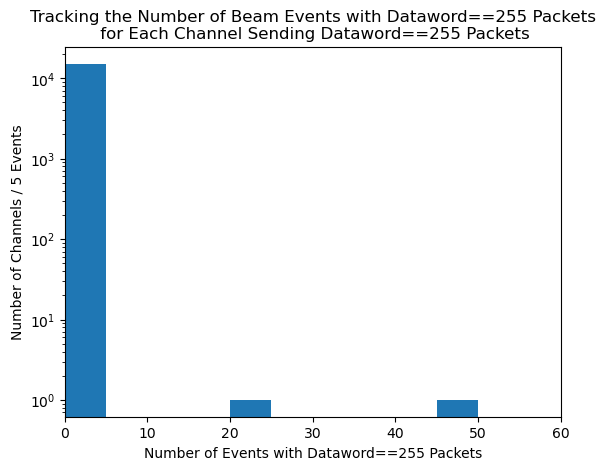

In [55]:
# Open and refine dictionary (slight differences for different dictionary versions)

# Open dictionary with ADC Saturation BEAM events
adc_sat_file = '/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/event_display/LAr_evd/adc_saturation_beam_events_dict.json'
adc_sat_open = open(adc_sat_file)
adc_sat_dict = json.load(adc_sat_open)

# Open dictionary with ADC Saturation BEAM events -- version of dictionary removing events with ADC saturation packets only coming from a few
# previously identified noisy chips/channels
adc_sat_file = '/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/event_display/LAr_evd/adc_saturation_beam_events_V5_REMOVE_NOISY_PIXELS_dict.json'
adc_sat_open = open(adc_sat_file)
adc_sat_dict = json.load(adc_sat_open)

# Open dictionary with ADC Saturation BEAM events v3 (just sandbox -- trying to look at smaller sample with the newest version available at this time)
#adc_sat_file_V3_SANDBOX = '/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/event_display/LAr_evd/adc_saturation_beam_events_V3_SANDBOX_dict.json'
#adc_sat_open_V3_SANDBOX = open(adc_sat_file_V3_SANDBOX)
#adc_sat_V3_SANDBOX_dict = json.load(adc_sat_open_V3_SANDBOX)

# Exclude LRS Low Threshold events (originally included full run in dictionary)
adc_sat_dict = {k: v for k, v in adc_sat_dict.items() if 'low_threshold' not in k}
print("Length of original dictionary: ", len(adc_sat_dict))
print("Length of dictionary after excluding LRS Low Threshold events: ", len(adc_sat_dict))

In [ ]:
# SPECIFICALLY for ADC saturation packet dictionary including "noisy chips" (i.e. chips with more than 5 events with ADC saturation packets)
# HOWEVER, in addition to identifying noisy chips, this cell also defines certain variables used later in the notebook (i.e. unique_channels_with_adc_sat_packets)

# Get list of unique channels with ADC Saturation packets (using io channel and then network agnostic i.e. using tile number)
unique_channels_with_adc_sat_packets = [adc_sat_dict[k]['unique_channels_impacted'] for k in adc_sat_dict.keys()]
print(unique_channels_with_adc_sat_packets)
unique_channels_per_event = unique_channels_with_adc_sat_packets
unique_channels_with_adc_sat_packets = np.array([item for sublist in unique_channels_with_adc_sat_packets for item in sublist])
#print("Unique channels with ADC Saturation packets: ", unique_channels_with_adc_sat_packets[:20])
unique_channels_with_adc_sat_packets_network_agnostic = np.array([
    [channel[0], io_channel_to_tile(channel[1]), channel[2], channel[3]] for channel in unique_channels_with_adc_sat_packets
])
#print("Unique channels with ADC Saturation packets: ", unique_channels_with_adc_sat_packets_network_agnostic[:20])

# Identification of noisy channels
adc_sat_channels_ioch, adc_sat_channels_counts_ioch = np.unique(unique_channels_with_adc_sat_packets, axis=0, return_counts=True)
#print(len(adc_sat_channels_ioch))
noisy_channels_ioch = np.where(adc_sat_channels_counts_ioch>=5)
normal_channels_ioch = np.where(adc_sat_channels_counts_ioch<5)
print("Noisy channels: ", adc_sat_channels_ioch[noisy_channels_ioch]) 
print("Number of noisy channels: ", len(adc_sat_channels_ioch[noisy_channels_ioch]))
adc_sat_channels, adc_sat_channels_counts = np.unique(unique_channels_with_adc_sat_packets_network_agnostic, axis=0, return_counts=True)
#print(len(adc_sat_channels))
#print(len(adc_sat_channels_counts[adc_sat_channels_counts>1]))
#print(len(adc_sat_channels_counts[adc_sat_channels_counts>5]))
#print(len(adc_sat_channels_counts[adc_sat_channels_counts>100]))
noisy_channels = np.where(adc_sat_channels_counts>=5)
normal_channels = np.where(adc_sat_channels_counts<5)
print("Noisy channels:", adc_sat_channels[noisy_channels])
print("Number of noisy channels:", len(adc_sat_channels[noisy_channels]))

# Plot histogram of number of events with dataword==255 packets for each channel sending dataword==255 packets
plt.hist(adc_sat_channels_counts, bins=np.linspace(0, 1600, 321))
plt.yscale('log')
plt.ylabel('Number of Channels / 5 Events')
plt.xlabel('Number of Events with Dataword==255 Packets')
plt.title('Tracking the Number of Beam Events with Dataword==255 Packets\n for Each Channel Sending Dataword==255 Packets')
plt.xlim(0, 60)

In [32]:
# NOISY CHIP IDENTIFICATION AND REMOVAL FROM DICTIONARY
# This cell is mostly relevant for a version of the dictionary that includes "noisy chips" (i.e. chips with more than 5 events with ADC saturation packets)
# However, this cell is dependent on the "noisy chips" already being identified as such. For early 2x2 data (July 2024), the noisy chips are:
# 2/29/31, 6/7/99, 8/21/13, 2/17/21 (the latter is not included in this cell) -- these are listed by iogroup/iochannel/chip_id
# The current script (as of 2024-10-07) uses a version of the dictionary that has already removed events with ADC saturation packets only coming from noisy chips

#print(adc_sat_channels_ioch[noisy_channels_ioch].tolist())

print("Total number of unique channels:", len(adc_sat_channels))
print("Number of noisy channels:", len(adc_sat_channels[noisy_channels]))
# Filter noisy chips:
#print(adc_sat_channels)
noisy_chips = []
normal_chips = []
for i in range(len(adc_sat_channels)):
    if adc_sat_channels[i][0] == 2 and adc_sat_channels[i][1] == 8 and adc_sat_channels[i][2] == 31:
        noisy_chips.append(i)
        #print(adc_sat_channels[i])
    elif adc_sat_channels[i][0] == 6 and adc_sat_channels[i][1] == 2 and adc_sat_channels[i][2] == 99:
        noisy_chips.append(i)
        #print(adc_sat_channels[i])
    elif adc_sat_channels[i][0] == 8 and adc_sat_channels[i][1] == 6 and adc_sat_channels[i][2] == 13:
        noisy_chips.append(i)
        #print(adc_sat_channels[i])
    else:
        normal_chips.append(i)
print("Number of channels on noisy chips:", len(adc_sat_channels[noisy_chips]))
print("Number of channels on normal chips:", len(adc_sat_channels[normal_chips]))
print("Noisy chips channels:", len(adc_sat_channels_ioch[noisy_chips]))
print("Normal chips channels:", len(adc_sat_channels[normal_chips]))

print("Total number of unique channels:", len(adc_sat_channels_ioch))
print("Number of noisy channels:", len(adc_sat_channels_ioch[noisy_channels]))
# Filter noisy chips:
#print(adc_sat_channels)
noisy_chips_ioch = []
normal_chips_ioch = []
for i in range(len(adc_sat_channels_ioch)):
    if adc_sat_channels_ioch[i][0] == 2 and adc_sat_channels_ioch[i][1] == 29 and adc_sat_channels_ioch[i][2] == 31:
        noisy_chips_ioch.append(i)
        #print(adc_sat_channels[i])
    elif adc_sat_channels_ioch[i][0] == 6 and adc_sat_channels_ioch[i][1] == 7 and adc_sat_channels_ioch[i][2] == 99:
        noisy_chips_ioch.append(i)
        #print(adc_sat_channels[i])
    elif adc_sat_channels_ioch[i][0] == 8 and adc_sat_channels_ioch[i][1] == 21 and adc_sat_channels_ioch[i][2] == 13:
        noisy_chips_ioch.append(i)
        #print(adc_sat_channels[i])
    else:
        normal_chips_ioch.append(i)
print("Number of channels on noisy chips:", len(adc_sat_channels_ioch[noisy_chips_ioch]))
print("Number of channels on normal chips:", len(adc_sat_channels_ioch[normal_chips_ioch]))
print("Noisy chips channels:", len(adc_sat_channels_ioch[noisy_chips_ioch]))
print("Normal chips channels:", len(adc_sat_channels_ioch[normal_chips_ioch]))



# Check noisy channel on iog six
#print(adc_sat_channels[noisy_channels][0])
#for keys, values in adc_sat_dict.items():
#    #if not all(channel != chan.tolist() for chan in adc_sat_channels_ioch[noisy_channels_ioch] for channel in values['unique_channels_impacted']):
#    #    print(keys)
#    #    print(values['unique_channels_impacted'])
#    if any(channel == chan.tolist() for chan in adc_sat_channels_ioch[normal_channels_ioch] for channel in values['unique_channels_impacted'])\
#    and any(channel == chan.tolist() for chan in adc_sat_channels_ioch[noisy_channels_ioch] for channel in values['unique_channels_impacted']):
#        #print(keys)
#        print(values['unique_channels_impacted'])
    #if map(lambda x: not all(x in adc_sat_channels_ioch[noisy_channels_ioch].tolist()), values['unique_channels_impacted']):
     #   print(values['unique_channels_impacted'])
    #if all(chan.tolist() not in values['unique_channels_impacted'] for chan in adc_sat_channels[noisy_channels]):
    #for chan in adc_sat_channel_ioch[noisy_channels_ioch]:
    #    if chan.tolist() in values['unique_channels_impacted']:
    #        print(values['unique_channels_impacted'])

adc_sat_dict_remove_noisy_channels = {
    k: v for k, v in adc_sat_dict.items()
    if any(channel == chan.tolist() for chan in adc_sat_channels_ioch[normal_chips_ioch] for channel in v['unique_channels_impacted'])
   #if any(channel not in adc_sat_channels_ioch[noisy_channels_ioch].tolist() for channel in values['unique_channels_impacted'])
   #if all(channel != chan.tolist() for chan in adc_sat_channels_ioch[noisy_channels_ioch] for channel in v['unique_channels_impacted']) 
    #if any(any(channel != chan.tolist() for chan in adc_sat_channels_ioch[noisy_channels_ioch]) and any(channel == chan.tolist() for chan in adc_sat_channels_ioch[noisy_channels_ioch]) for channel in values['unique_channels_impacted'])
    #if (not all(channel != chan.tolist() for chan in adc_sat_channels_ioch[noisy_channels_ioch] for channel in v['unique_channels_impacted']) and any(channel == chan.tolist() for chan in adc_sat_channels_ioch[noisy_channels_ioch] for channel in v['unique_channels_impacted']))
    #if not any(all(channel == chan.tolist() for channel in v['unique_channels_impacted']) for chan in adc_sat_channels_ioch[noisy_channels_ioch])
}
#for keys, values in adc_sat_dict_remove_noisy_channels.items():
#    if [6,7,99,12] in values['unique_channels_impacted']:
    #print(keys)
    #print(values['unique_channels_impacted'])
    #if all(chan.tolist() not in values['unique_channels_impacted'] for chan in adc_sat_channels[noisy_channels]):
    #for chan in adc_sat_channels_ioch[noisy_channels_ioch]:
    #    if chan.tolist() in values['unique_channels_impacted']:
    #        print(values['unique_channels_impacted'])
#

Total number of unique channels: 15075
Number of noisy channels: 55
Number of channels on noisy chips: 69
Number of channels on normal chips: 15006
Noisy chips channels: 69
Normal chips channels: 15006
Total number of unique channels: 15075
Number of noisy channels: 55
Number of channels on noisy chips: 69
Number of channels on normal chips: 15006
Noisy chips channels: 69
Normal chips channels: 15006


In [54]:
# Again, this cell is primarily concerned with refining the dictionary to remove events with ADC saturation packets only coming from noisy chips (or removing
# noisy chip packets from events with additional ADC saturation packets)

unique_channels_with_adc_sat_packets = [adc_sat_dict_remove_noisy_channels[k]['unique_channels_impacted'] for k in adc_sat_dict_remove_noisy_channels.keys()]
subkeys = []
for key, subdict in adc_sat_dict.items():
    subkeys.extend(subdict.keys())

print(subkeys)
#counts_unique_channels_with_adc_sat_packets = [adc_sat_dict_remove_noisy_channels[k]['total_sat_packets_per_unique_channel'] for k in adc_sat_dict_remove_noisy_channels.keys()]
unique_channels_with_adc_sat_packets = np.array([item for sublist in unique_channels_with_adc_sat_packets for item in sublist])
#counts_unique_channels_with_adc_sat_packets = np.array([item for sublist in counts_unique_channels_with_adc_sat_packets for item in sublist])
#print(counts_unique_channels_with_adc_sat_packets)
print("Number of events before noisy channels removed:", len(adc_sat_dict))
print("Number of events without just noisy channels:", len(adc_sat_dict_remove_noisy_channels))

['event_id', 'filepath', 'timestamp', 'nhits', 'num_adc_saturation_packets', 'unique_channels_impacted', 'adc_sat_packets_per_unique_channel', 'is_beam', 'event_id', 'filepath', 'timestamp', 'nhits', 'num_adc_saturation_packets', 'unique_channels_impacted', 'adc_sat_packets_per_unique_channel', 'is_beam', 'event_id', 'filepath', 'timestamp', 'nhits', 'num_adc_saturation_packets', 'unique_channels_impacted', 'adc_sat_packets_per_unique_channel', 'is_beam', 'event_id', 'filepath', 'timestamp', 'nhits', 'num_adc_saturation_packets', 'unique_channels_impacted', 'adc_sat_packets_per_unique_channel', 'is_beam', 'event_id', 'filepath', 'timestamp', 'nhits', 'num_adc_saturation_packets', 'unique_channels_impacted', 'adc_sat_packets_per_unique_channel', 'is_beam', 'event_id', 'filepath', 'timestamp', 'nhits', 'num_adc_saturation_packets', 'unique_channels_impacted', 'adc_sat_packets_per_unique_channel', 'is_beam', 'event_id', 'filepath', 'timestamp', 'nhits', 'num_adc_saturation_packets', 'uniq

In [6]:
# Again, this cell is primarily concerned with refining the dictionary to remove events with ADC saturation packets only coming from noisy chips (or removing
# noisy chip packets from events with additional ADC saturation packets)


#print("Total number of unique channels:", len(adc_sat_channels))
#print("Number of noisy channels:", len(adc_sat_channels[noisy_channels]))
## Filter noisy chips:
##print(adc_sat_channels)
#noisy_chips = []
#normal_chips = []
#for i in range(len(adc_sat_channels)):
#    if adc_sat_channels[i][0] == 2 and adc_sat_channels[i][1] == 8 and adc_sat_channels[i][2] == 31:
#        noisy_chips.append(i)
#        #print(adc_sat_channels[i])
#    elif adc_sat_channels[i][0] == 6 and adc_sat_channels[i][1] == 2 and adc_sat_channels[i][2] == 99:
#        noisy_chips.append(i)
#        #print(adc_sat_channels[i])
#    elif adc_sat_channels[i][0] == 8 and adc_sat_channels[i][1] == 6 and adc_sat_channels[i][2] == 13:
#        noisy_chips.append(i)
#        #print(adc_sat_channels[i])
#    else:
#        normal_chips.append(i)
#print("Number of channels on noisy chips:", len(adc_sat_channels[noisy_chips]))
#print("Number of channels on normal chips:", len(adc_sat_channels[normal_chips]))

In [7]:
# This cell is concerned with getting lists of main values for the dictionary (i.e. number of hits, number of ADC saturation packets, etc.) 
# This redundancy from above was necessary for previous use of the dictionary, but is not necessary for the current version of the dictionary
# as the newest dictionary by default exclude events with ADC saturation packets only coming from noisy chips.
# TODO: Remove this cell if not necessary and/or combine with cells above


# Get lists of main values: 
nhits_per_event = np.array([adc_sat_dict[k]['nhits'] for k in adc_sat_dict.keys()])
print(len(nhits_per_event))
n_adc_sat_packets_per_event = np.array([adc_sat_dict[k]['num_adc_saturation_packets'] for k in adc_sat_dict.keys()])
iog_with_adc_sat_packets = unique_channels_with_adc_sat_packets[:,0]
#print(unique_channels_per_event[:20])
iog_with_adc_sat_packets_per_event = [set([channel[0] for channel in unique_channels_per_event[i]]) for i in range(len(unique_channels_per_event))]
#print(iog_with_adc_sat_packets_per_event[20:34])
#print("IOG with ADC Saturation packets: ", iog_with_adc_sat_packets[:20])
iog_with_adc_sat_packets_counts_per_event = Counter(map(tuple, iog_with_adc_sat_packets_per_event))
#print(iog_with_adc_sat_packets_counts_per_event)
iog_combinations = [iog for iog in iog_with_adc_sat_packets_counts_per_event.keys()]
#print(iog_combinations)
iog_with_adc_sat_packets_counts = np.array([iog for iog in iog_with_adc_sat_packets_counts_per_event.values()])
#print(iog_with_adc_sat_packets_counts)

# list of main values without noisy channels:
#print(unique_channels_per_event[:20])
#print(adc_sat_channels[noisy_channels])
print(unique_channels_per_event[:10])
nhits_per_event_remove_noisy_channels = np.array([adc_sat_dict_remove_noisy_channels[k]['nhits'] for k in adc_sat_dict_remove_noisy_channels.keys()])
print(len(nhits_per_event_remove_noisy_channels))
n_adc_sat_packets_per_event_remove_noisy_channels = np.array([adc_sat_dict_remove_noisy_channels[k]['num_adc_saturation_packets'] for k in adc_sat_dict_remove_noisy_channels.keys()])

            
iog_with_adc_sat_packets_remove_noisy_channels = [set([channel[0] for channel in unique_channels_per_event[i] if any(channel == chan.tolist() for chan in adc_sat_channels_ioch[normal_chips_ioch])]) for i in range(len(unique_channels_per_event))]
channelid_with_adc_sat_packets_remove_noisy_channels = [[channel[3] for channel in unique_channels_per_event[i] if any(channel == chan.tolist() for chan in adc_sat_channels_ioch[normal_chips_ioch])] for i in range(len(unique_channels_per_event))]
iog_with_adc_sat_packets_counts_per_event_remove_noisy_channels = Counter(map(tuple, iog_with_adc_sat_packets_remove_noisy_channels))
print(iog_with_adc_sat_packets_counts_per_event_remove_noisy_channels)

5659
[[[7, 1, 29, 41], [7, 1, 34, 60]], [[4, 10, 49, 12]], [[6, 20, 85, 38], [6, 20, 88, 37], [6, 20, 88, 38]], [[6, 9, 14, 12]], [[2, 13, 19, 32]], [[8, 17, 25, 34], [8, 17, 40, 59]], [[6, 17, 22, 37]], [[5, 7, 65, 52]], [[7, 12, 97, 59]], [[5, 7, 63, 17]]]
3810
Counter({(): 1849, (2,): 534, (1,): 527, (3,): 512, (4,): 458, (7,): 446, (5,): 409, (8,): 371, (6,): 305, (2, 4): 68, (1, 3): 51, (8, 6): 37, (5, 7): 32, (1, 2): 4, (5, 6): 4, (4, 7): 4, (1, 4): 4, (2, 7): 3, (6, 7): 3, (3, 4): 3, (4, 5): 3, (2, 3): 2, (5, 6, 7): 2, (8, 7): 2, (2, 3, 4): 2, (2, 5, 7): 2, (8, 5, 6): 2, (2, 6): 2, (4, 6): 2, (3, 7): 2, (8, 5, 7): 1, (3, 6): 1, (8, 1): 1, (1, 2, 3, 4): 1, (2, 5): 1, (8, 2): 1, (1, 5): 1, (1, 7): 1, (8, 2, 6): 1, (8, 2, 4): 1, (2, 6, 7): 1, (8, 5): 1, (8, 1, 6): 1, (8, 3): 1})


Text(0.5, 1.0, 'ADC Saturation Packets IOGs by Event')

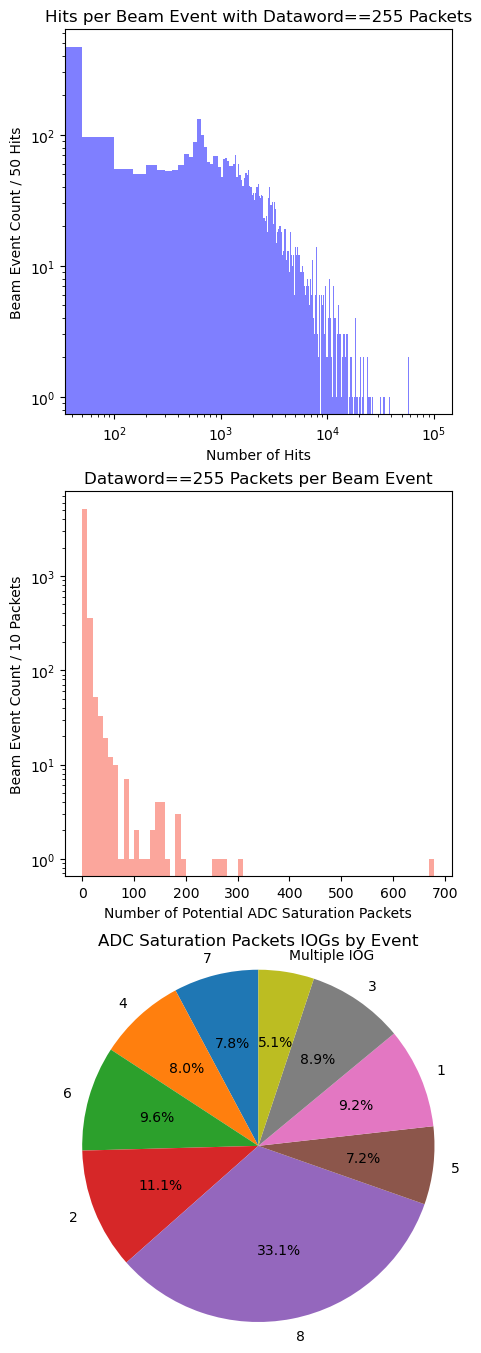

In [11]:
# Plot histograms of nhits per events and number of ADC saturation packets per event, and show pie chart of IOGs with ADC saturation packets

fig, axs = plt.subplots(3,1, figsize=(5,17))

max_nhits = math.ceil(max(nhits_per_event)/100)*100
min_nhits = math.floor(min(nhits_per_event)/100)*100
axs[0].hist(nhits_per_event, bins=int((max_nhits-min_nhits)/50), range=(min_nhits, max_nhits), color='b', alpha=0.5)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_title('Hits per Beam Event with Dataword==255 Packets')
axs[0].set_xlabel('Number of Hits')
axs[0].set_ylabel('Beam Event Count / 50 Hits')

max_adc_sat_packets = math.ceil(max(n_adc_sat_packets_per_event)/10)*10
min_adc_sat_packets = math.floor(min(n_adc_sat_packets_per_event)/10)*10
axs[1].hist(n_adc_sat_packets_per_event, bins=int((max_adc_sat_packets-min_adc_sat_packets)/10), range=(min_adc_sat_packets, max_adc_sat_packets), color='salmon', alpha=0.7)
axs[1].set_yscale('log')
axs[1].set_title('Dataword==255 Packets per Beam Event')
axs[1].set_xlabel('Number of Potential ADC Saturation Packets')
axs[1].set_ylabel('Beam Event Count / 10 Packets')

other_size = 0
labels= []
sizes = []
for key, value in iog_with_adc_sat_packets_counts_per_event.items():
    if len(key) > 1:
        other_size += value
    else:
        labels.append(str(key[0]))
        sizes.append(value)
if other_size > 0:
    labels.append('Multiple IOG')
    sizes.append(other_size)
axs[2].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axs[2].axis('equal')
axs[2].set_title('ADC Saturation Packets IOGs by Event')

[ 52917  68363  61119  50039  54062  57980  52330  56187 101622  56960
  60871  60758  57964  51701  73604  54187  56953  50022  62382  65069
  62368  59682  50107  61329  52673  59138]
['Multiple', '8', '7', '6', '5', '4', '3', '2', '1']
[248. 371. 446. 305. 409. 458. 512. 534. 527.]


Text(0.5, 1.0, 'Beam-Related ADC Saturation Packets IO Groups by Event')

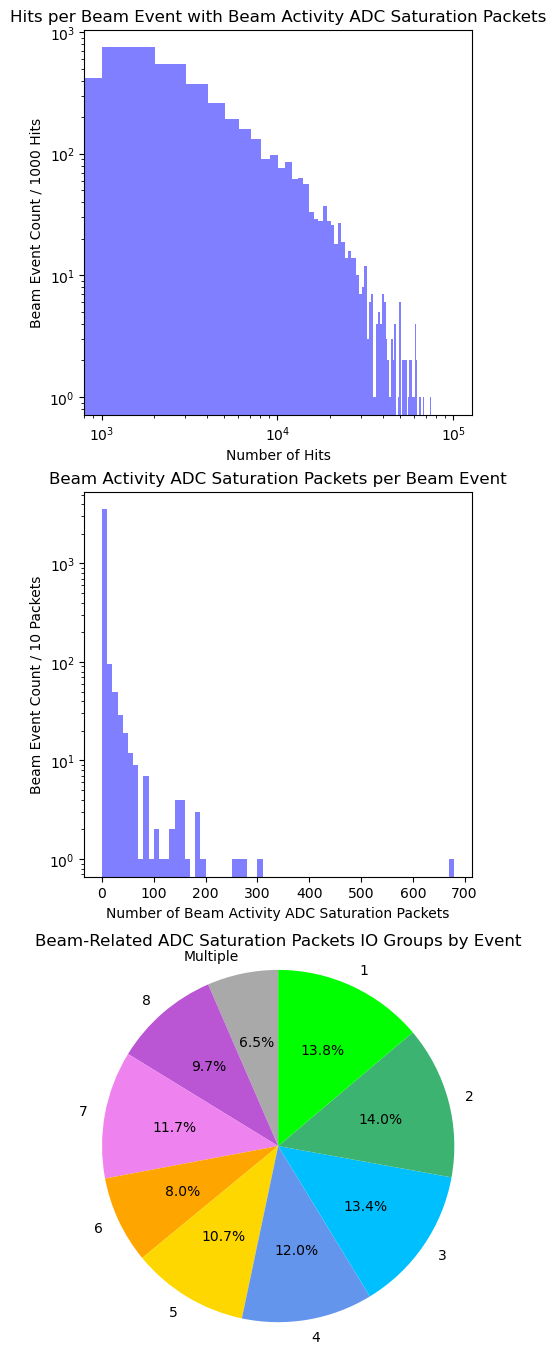

In [29]:
# Plot histograms of nhits per events and number of ADC saturation packets per event, and show pie chart of IOGs with ADC saturation packets
# This cell is redundant with the previous cell if the original dictionary removed noisy chip packets


fig, axs = plt.subplots(3,1, figsize=(5,17))

max_nhits = math.ceil(max(nhits_per_event_remove_noisy_channels)/100)*100
min_nhits = math.floor(min(nhits_per_event_remove_noisy_channels)/100)*100
print(nhits_per_event_remove_noisy_channels[nhits_per_event_remove_noisy_channels>50000])
axs[0].hist(nhits_per_event_remove_noisy_channels, bins=int((max_nhits-min_nhits)/1000), range=(min_nhits, max_nhits), color='b', alpha=0.5)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_title('Hits per Beam Event with Beam Activity ADC Saturation Packets')
axs[0].set_xlabel('Number of Hits')
axs[0].set_ylabel('Beam Event Count / 1000 Hits')

max_adc_sat_packets = math.ceil(max(n_adc_sat_packets_per_event_remove_noisy_channels)/10)*10
min_adc_sat_packets = math.floor(min(n_adc_sat_packets_per_event_remove_noisy_channels)/10)*10
axs[1].hist(n_adc_sat_packets_per_event_remove_noisy_channels, bins=int((max_adc_sat_packets-min_adc_sat_packets)/10), range=(min_adc_sat_packets, max_adc_sat_packets), color='b', alpha=0.5)
axs[1].set_yscale('log')
axs[1].set_title('Beam Activity ADC Saturation Packets per Beam Event')
axs[1].set_xlabel('Number of Beam Activity ADC Saturation Packets')
axs[1].set_ylabel('Beam Event Count / 10 Packets')

other_size = 0
labels= ['', '', '', '', '', '', '', '', '']
sizes = np.zeros(9)
for key, value in iog_with_adc_sat_packets_counts_per_event_remove_noisy_channels.items():
    if len(key) > 1:
        other_size += value
    elif len(key) == 1:
        labels[9-key[0]]=str(key[0])
        sizes[9-key[0]]=value
    else:
        continue
if other_size > 0:
    labels[0] = 'Multiple'
    sizes[0] =other_size
print(labels)
print(sizes)
colors = ['darkgray', 'mediumorchid', 'violet', 'orange', 'gold',\
          'cornflowerblue', 'deepskyblue','mediumseagreen', 'lime']
axs[2].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[2].axis('equal')
axs[2].set_title('Beam-Related ADC Saturation Packets IO Groups by Event')


In [10]:
# This cell is very exploratory and is not necessary for the main ADC Saturation packet analysis. It is used to identify events with ADC saturation packets
# which also include WTT. WTT is relatively uncommon in 2x2. To make a dictionary of 2x2 events with WTT, look in the whole_tile_triggering directory of 
# scripts/low_level_data_ana/charge_data_feature_studies. This cell saves dictionaries of events with ADC saturation removing WTT events.
how_many_events = 0
for k,v in adc_sat_dict_remove_noisy_channels.items():
    if v['num_adc_saturation_packets'] > 70:
        print(k, v['num_adc_saturation_packets'], np.unique(np.array(v['unique_channels_impacted'])[:,0]))
        how_many_events += 1
print("Number of events with more than 70 ADC Saturation packets: ", how_many_events)
full_tile_file = '/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/event_display/LAr_evd/full_tile_trigger_dict.json'
full_tile_open = open(full_tile_file)
full_tile_trigger_dict = json.load(full_tile_open)

how_much_overlap = 0
beam_events_with_full_tile_trigger = 0
for k,v in full_tile_trigger_dict.items():
    if adc_sat_dict_remove_noisy_channels.get(k):
        #if not any(v['event_full_tile_spike']):
        #print(k, adc_sat_dict[k]['num_adc_saturation_packets'], np.unique(np.array(adc_sat_dict[k]['unique_channels_impacted'])[:,0]))
        how_much_overlap += 1

print("Number of events in ADC Saturation dict: ", len(adc_sat_dict_remove_noisy_channels))
print("Number of overlapping events: ", how_much_overlap)

adc_sat_dict_remove_noisy_channels_NOT_full_tile = {
    k: v for k, v in adc_sat_dict_remove_noisy_channels.items()
    if not full_tile_trigger_dict.get(k)
}
adc_sat_dict_remove_noisy_channels_full_tile_trigger = {
    k: v for k, v in adc_sat_dict_remove_noisy_channels.items()
    if full_tile_trigger_dict.get(k)
}
print("Number of events in ADC Saturation dict: ", len(adc_sat_dict_remove_noisy_channels))
print("Number of events in ADC Saturation dict NOT in full tile dict: ", len(adc_sat_dict_remove_noisy_channels_NOT_full_tile))
print("Number of events in ADC Saturation dict in full tile dict: ", len(adc_sat_dict_remove_noisy_channels_full_tile_trigger))


# list of main values without noisy channels:


    

/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v1/beam/july8_2024/nominal_hv/packet-0050017-2024_07_08_13_53_27_CDT.FLOW.hdf5-28656 82 [2 4]
/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v1/beam/july8_2024/nominal_hv/packet-0050017-2024_07_09_12_15_51_CDT.FLOW.hdf5-1996 104 [2 4]
/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v1/beam/july8_2024/nominal_hv/packet-0050017-2024_07_09_08_35_27_CDT.FLOW.hdf5-4058 89 [5]
/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v1/beam/july8_2024/nominal_hv/packet-0050017-2024_07_10_00_27_09_CDT.FLOW.hdf5-2648 84 [5]
/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v1/beam/july8_2024/nominal_hv/packet-0050017-2024_07_10_04_17_33_CDT.FLOW.hdf5-3977 156 [2 4]
/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v1/beam/july8_2024/nominal_hv/packet-0050017-2024_07_09_04_04_58_CDT.FLOW.hdf5-5903 90 [1 3]
/global/cfs/cdirs/dune/www/data/2x2/nearline/fl

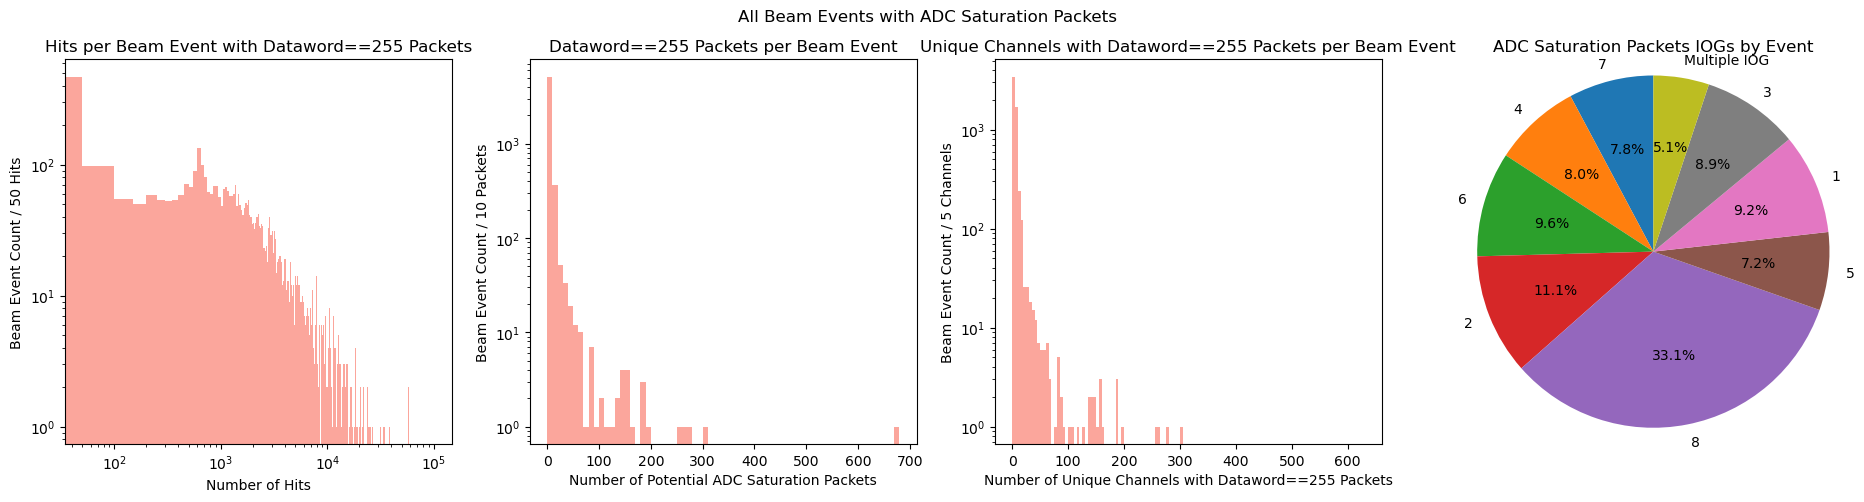

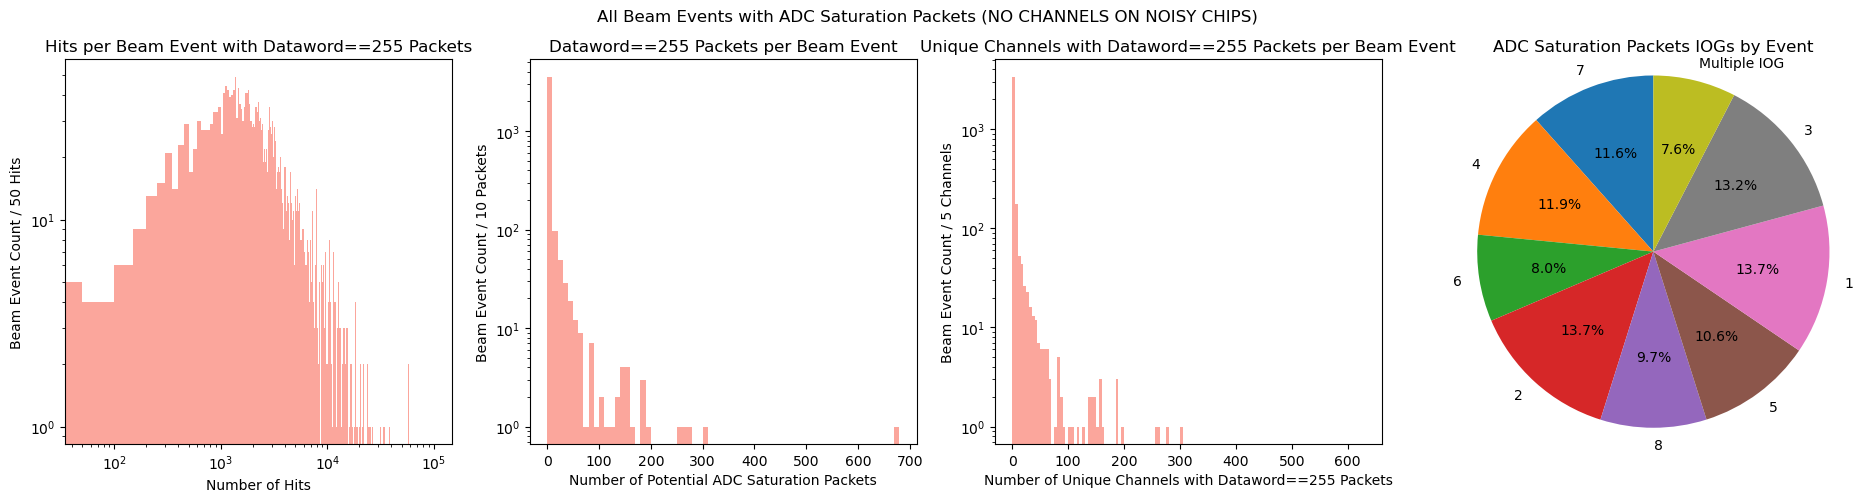

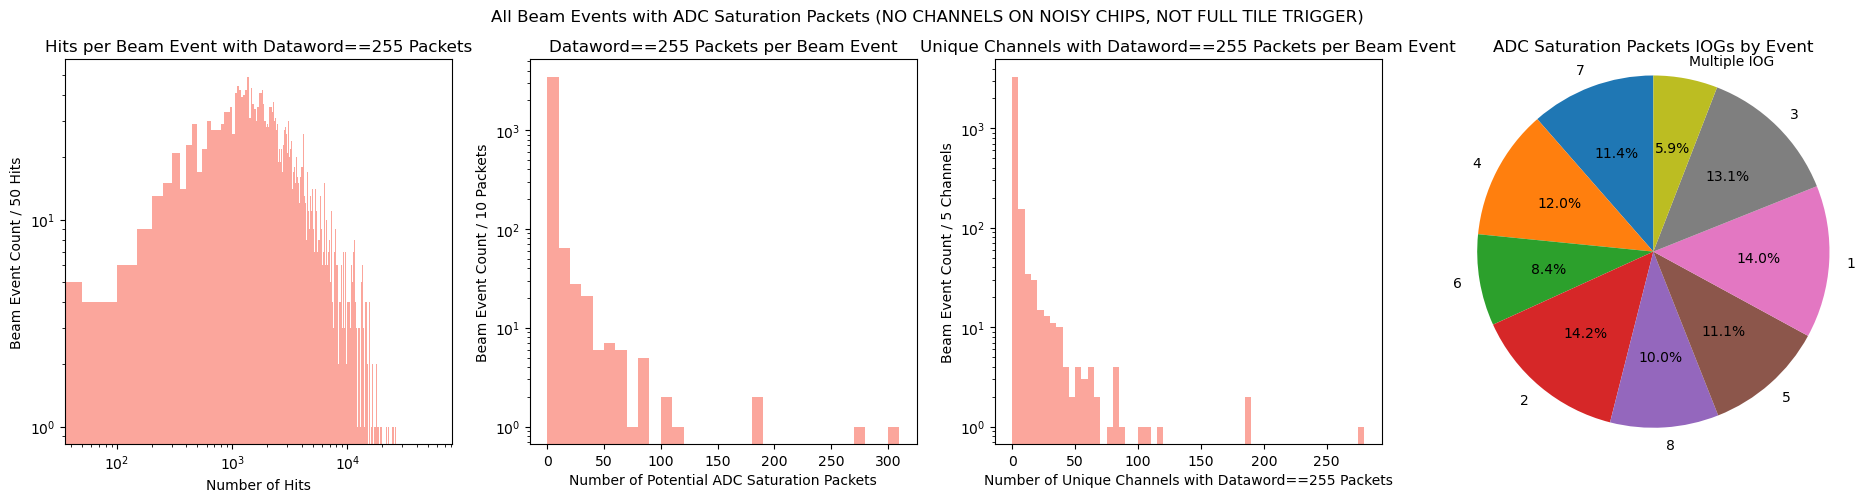

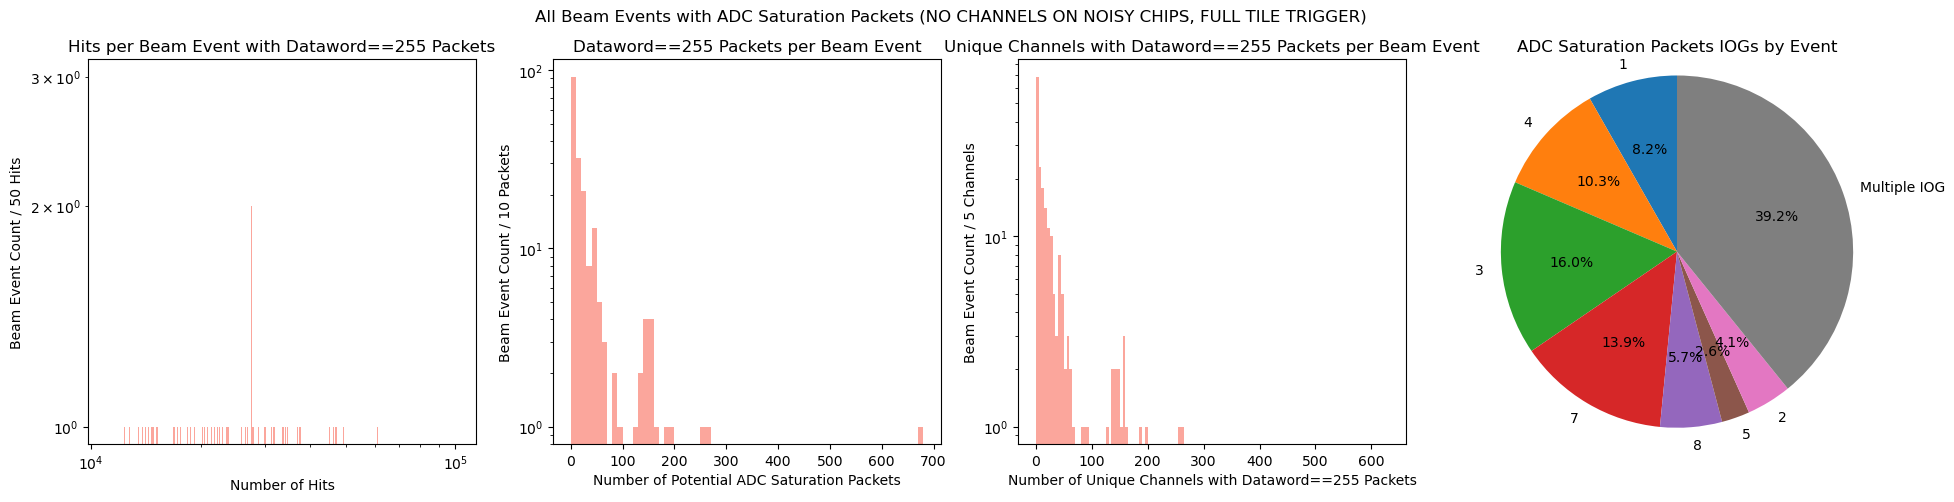

In [11]:
# This cell creates a method to make the plots above and runs this plotting method on multiple dictionary versions

def make_general_plots(dict_to_plot, title):

    nhits_per_event = np.array([dict_to_plot[k]['nhits'] for k in dict_to_plot.keys()])
   
    n_adc_sat_packets_per_event = np.array([dict_to_plot[k]['num_adc_saturation_packets'] for k in dict_to_plot.keys()])
    n_unique_channels_with_adc_sat_packets = [len(dict_to_plot[k]['unique_channels_impacted']) for k in dict_to_plot.keys()]
    iog_with_adc_sat_packets = [np.unique(np.array(v['unique_channels_impacted'])[:,0]) for v in dict_to_plot.values()]
    iog_with_adc_sat_packets_counts_per_event = Counter(map(tuple, iog_with_adc_sat_packets))

    fig, axs = plt.subplots(1,4, figsize=(23, 5))

    max_nhits = math.ceil(max(nhits_per_event)/100)*100
    min_nhits = math.floor(min(nhits_per_event)/100)*100
    
    axs[0].hist(nhits_per_event, bins=int((max_nhits-min_nhits)/50), range=(min_nhits, max_nhits), color='salmon', alpha=0.7)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_title('Hits per Beam Event with Dataword==255 Packets')
    axs[0].set_xlabel('Number of Hits')
    axs[0].set_ylabel('Beam Event Count / 50 Hits')

    max_adc_sat_packets = math.ceil(max(n_adc_sat_packets_per_event)/10)*10
    min_adc_sat_packets = math.floor(min(n_adc_sat_packets_per_event)/10)*10
    axs[1].hist(n_adc_sat_packets_per_event, bins=int((max_adc_sat_packets-min_adc_sat_packets)/10), range=(min_adc_sat_packets, max_adc_sat_packets), color='salmon', alpha=0.7)
    axs[1].set_yscale('log')
    axs[1].set_title('Dataword==255 Packets per Beam Event')
    axs[1].set_xlabel('Number of Potential ADC Saturation Packets')
    axs[1].set_ylabel('Beam Event Count / 10 Packets')

    max_unique_channels_with_adc_sat_packets = math.ceil(max(n_unique_channels_with_adc_sat_packets)/10)*10
    min_unique_channels_with_adc_sat_packets = math.floor(min(n_unique_channels_with_adc_sat_packets)/10)*10
    axs[2].hist(n_adc_sat_packets_per_event, bins=int((max_unique_channels_with_adc_sat_packets-min_unique_channels_with_adc_sat_packets)/5), range=(min_unique_channels_with_adc_sat_packets, max_unique_channels_with_adc_sat_packets), color='salmon', alpha=0.7)
    axs[2].set_yscale('log')
    axs[2].set_title('Unique Channels with Dataword==255 Packets per Beam Event')
    axs[2].set_xlabel('Number of Unique Channels with Dataword==255 Packets')
    axs[2].set_ylabel('Beam Event Count / 5 Channels')

    other_size = 0
    labels= []
    sizes = []
    for key, value in iog_with_adc_sat_packets_counts_per_event.items():
        if len(key) > 1:
            other_size += value
        elif len(key) == 1:
            labels.append(str(key[0]))
            sizes.append(value)
        else:
            continue
    if other_size > 0:
        labels.append('Multiple IOG')
        sizes.append(other_size)
    axs[3].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    axs[3].axis('equal')
    axs[3].set_title('ADC Saturation Packets IOGs by Event')
    fig.suptitle(title)


make_general_plots(adc_sat_dict, 'All Beam Events with ADC Saturation Packets')
make_general_plots(adc_sat_dict_remove_noisy_channels, 'All Beam Events with ADC Saturation Packets (NO CHANNELS ON NOISY CHIPS)')
make_general_plots(adc_sat_dict_remove_noisy_channels_NOT_full_tile, 'All Beam Events with ADC Saturation Packets (NO CHANNELS ON NOISY CHIPS, NOT FULL TILE TRIGGER)')
make_general_plots(adc_sat_dict_remove_noisy_channels_full_tile_trigger, 'All Beam Events with ADC Saturation Packets (NO CHANNELS ON NOISY CHIPS, FULL TILE TRIGGER)')

In [11]:
# This cell attempts to identify events with very low and very high rates of ADC saturation packets.

#for keys, values in adc_sat_dict_remove_noisy_channels.items():
#    print(keys)
#    print(values['unique_channels_impacted'])
adc_sat_dict_few_adc_sat_packets = {
    k: v for k, v in adc_sat_dict_remove_noisy_channels.items()
    if v['num_adc_saturation_packets'] <= 10
}
adc_sat_dict_many_adc_sat_packets = {
    k: v for k, v in adc_sat_dict_remove_noisy_channels.items()
    if v['num_adc_saturation_packets'] > 5
}
print("Small hits:", len(adc_sat_dict_few_adc_sat_packets))
print("Large hits:", len(adc_sat_dict_many_adc_sat_packets))

Small hits: 3585
Large hits: 373


In [63]:
# This cell allows for the creation of a PDF showing events with ADC saturation with the relevant hits highlighted 
# (i.e. plotted over the event display with a blue X marker)

output_pdf_name = 'adc_saturation_beam_events_not_noise_second_200.pdf'
with PdfPages(output_pdf_name, keep_empty=False) as output:
    counter = 0
    for keys, values in adc_sat_dict_remove_noisy_channels.items():
        counter += 1
        #if counter < 101: continue
        if counter > 2: break
        file = values['filepath'].split('/')[-1]
        directory = values['filepath'].split('packet')[0]
        directory = directory.replace('v1', 'v4')
        print("Directory:", directory)
        ev_id = values['event_id']

        evd = LArEventDisplay(filedir=directory, filename=file, nhits=values['nhits']-1, ntrigs=0, show_light=False, show_colorbars=False, beam_only=True)
        hits, cmap, charge_norm = evd.display_event(ev_id)
        print("ADC Sat Hits:", len(hits[hits['Q']>245]))
        sat_hits = hits[hits['Q']>245]
        print("ADC Sat Packets:", values['num_adc_saturation_packets'])
        #print("File:", file)
        #print("Directory:", directory)
        #print("Event ID:", ev_id)
        evd.ax_bdv.scatter(sat_hits['z'], sat_hits['x'], sat_hits['y'], c='royalblue', s=25, alpha=0.70, marker='x', label=values['num_adc_saturation_packets'])
        evd.ax_bd.scatter(sat_hits['z'], sat_hits['x'], c='royalblue', s=25, alpha=0.70, marker='x')
        evd.ax_bv.scatter(sat_hits['z'], sat_hits['y'], c='royalblue', s=25, alpha=0.70, marker='x')
        evd.ax_dv.scatter(sat_hits['x'], sat_hits['y'], c='royalblue', s=25, alpha=0.70, marker='x')
        evd.ax_bdv.legend(title='Number of Dataword==255 Packets')
        output.savefig(bbox_inches='tight')
        plt.close()

Number of available events: 127
For fast-forwarding purposes, here is every 10th event number in your sample: [970, 1639, 2082, 2789, 3296, 3929, 4413, 4837, 5965, 6935, 7521, 8012]
Number of external triggers in this event: 1
External trigger information: [5] [4963419.] [4963419]
Event 7840 is a beam trigger event
ADC Sat Hits: 1
ADC Sat Packets: 1
Number of available events: 6
For fast-forwarding purposes, here is every 10th event number in your sample: []
Number of external triggers in this event: 1
External trigger information: [5] [1023927.] [1023927]
Event 8146 is a beam trigger event
ADC Sat Hits: 1
ADC Sat Packets: 1
Number of available events: 73
For fast-forwarding purposes, here is every 10th event number in your sample: [1269, 2303, 3413, 4378, 5014, 5730, 6457]
Number of external triggers in this event: 1
External trigger information: [5] [7684113.] [7684113]
Event 333 is a beam trigger event
ADC Sat Hits: 1
ADC Sat Packets: 1
Number of available events: 47
For fast-forwar

In [19]:
# This cell allows for the creation of a PDF showing events with ADC saturation with the relevant hits highlighted 
# (i.e. plotted over the event display with a blue X marker). The section commented out also plots events with negative charge hits from ADC drift

output_pdf_name = 'adc_saturation_beam_events_negative_charge_JUST_EVENTS.pdf'
with PdfPages(output_pdf_name, keep_empty=False) as output:
    counter = 0
    for keys, values in adc_sat_dict_remove_noisy_channels.items():
        counter += 1
        #if counter < 101: continue
        if counter > 10: break
        file = values['filepath'].split('/')[-1]
        directory = values['filepath'].split('packet')[0]
        ev_id = values['event_id']

        evd = LArEventDisplay(filedir=directory, filename=file, nhits=values['nhits']-1, ntrigs=0, show_light=False, show_colorbars=True, beam_only=True)
        hits, cmap, charge_norm = evd.display_event(ev_id)
        #print("ADC Sat Hits:", len(hits[hits['Q']<0]))
        #negative_charge_hits = hits[hits['Q']<0]
        #print("ADC Sat Packets:", values['num_adc_saturation_packets'])
        ##print("File:", file)
        ##print("Directory:", directory)
        ##print("Event ID:", ev_id)
        #evd.ax_bdv.scatter(negative_charge_hits['z'], negative_charge_hits['x'], negative_charge_hits['y'], c='aqua', s=25, alpha=0.50, marker='*', label=len(negative_charge_hits))
        #evd.ax_bd.scatter(negative_charge_hits['z'], negative_charge_hits['x'], c='aqua', s=25, alpha=0.50, marker='*')
        #evd.ax_bv.scatter(negative_charge_hits['z'], negative_charge_hits['y'], c='aqua', s=25, alpha=0.50, marker='*')
        #evd.ax_dv.scatter(negative_charge_hits['x'], negative_charge_hits['y'], c='aqua', s=25, alpha=0.50, marker='*')
        #evd.ax_bdv.legend(title='Number of Charge < 0 Hits')
        output.savefig(bbox_inches='tight')
        plt.close()

Number of available events: 9
For fast-forwarding purposes, here is every 10th event number in your sample: []
Number of external triggers in this event: 1
External trigger information: [5] [6536418.] [6536418]
Event 9 is a beam trigger event
Number of available events: 65
For fast-forwarding purposes, here is every 10th event number in your sample: [445, 1270, 1777, 2410, 2797, 3746]
Number of external triggers in this event: 1
External trigger information: [5] [5189709.] [5189709]
Event 273 is a beam trigger event
Number of available events: 4
For fast-forwarding purposes, here is every 10th event number in your sample: []
Number of external triggers in this event: 1
External trigger information: [5] [1658720.] [1658720]
Event 1000 is a beam trigger event
Number of available events: 25
For fast-forwarding purposes, here is every 10th event number in your sample: [1331, 2640]
Number of external triggers in this event: 1
External trigger information: [5] [7696044.] [7696044]
Event 2534

Directory: /global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v4/beam/july8_2024/nominal_hv/
Number of available events: 73
For fast-forwarding purposes, here is every 10th event number in your sample: [924, 1627, 3062, 4004, 4815, 5822, 6856]
Number of external triggers in this event: 1
Event 4324 is a beam trigger event
Number of available events: 73
For fast-forwarding purposes, here is every 10th event number in your sample: [924, 1627, 3062, 4004, 4815, 5822, 6856]
Number of external triggers in this event: 1
Event 4324 is a beam trigger event
Directory: /global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v4/beam/july8_2024/nominal_hv/
Number of available events: 110
For fast-forwarding purposes, here is every 10th event number in your sample: [670, 1352, 1678, 2823, 3526, 4160, 4690, 5260, 6102, 6421, 6951]
Number of external triggers in this event: 1
Event 5043 is a beam trigger event
Number of available events: 110
For fast-forwarding purposes, here

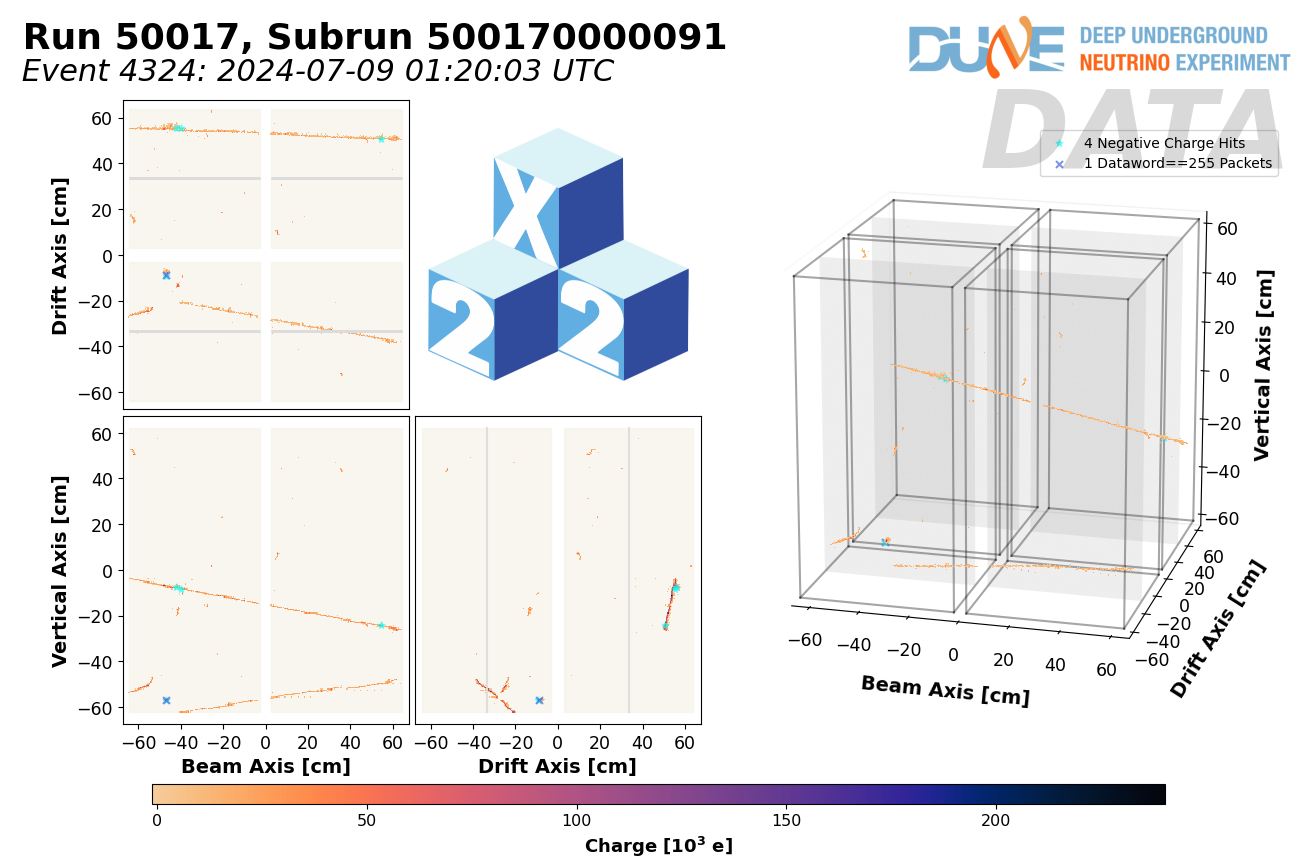

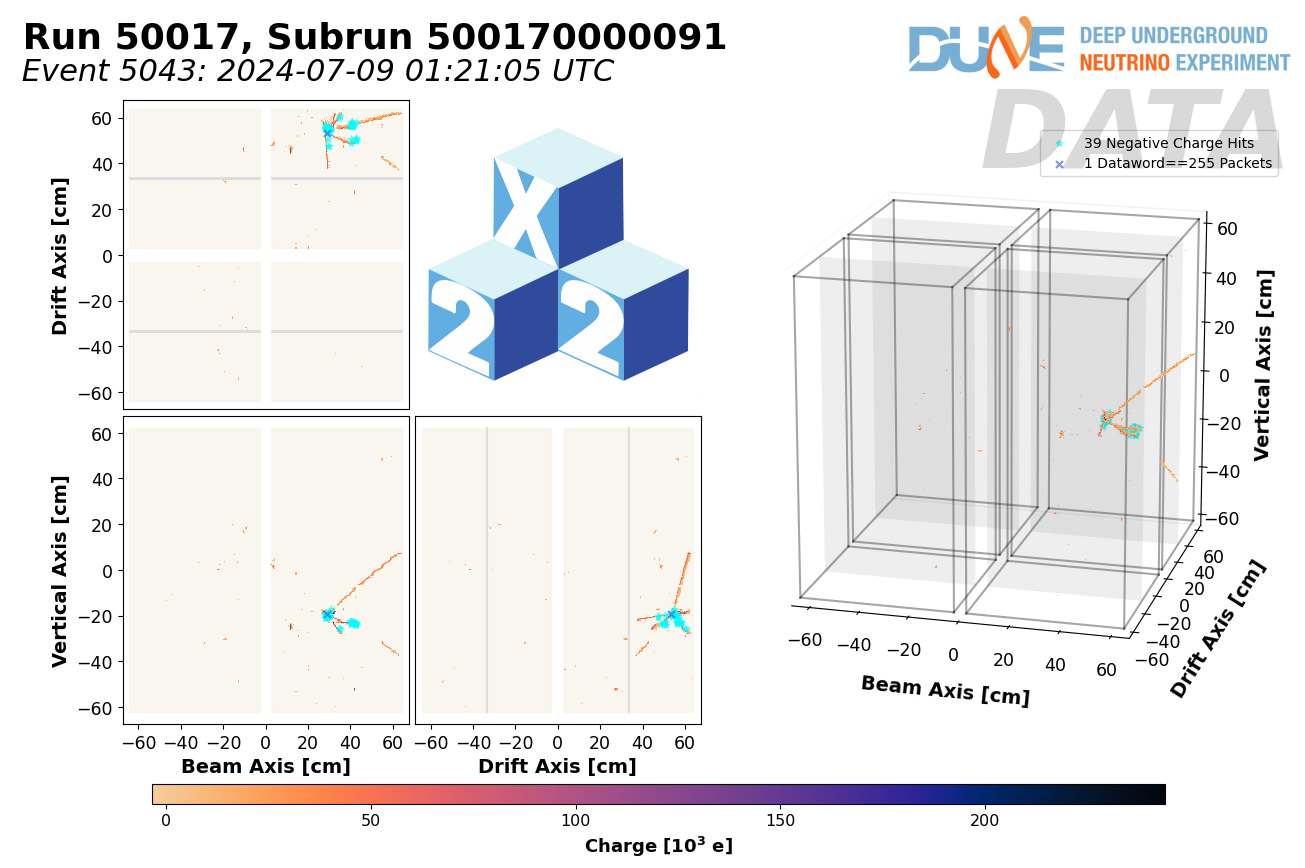

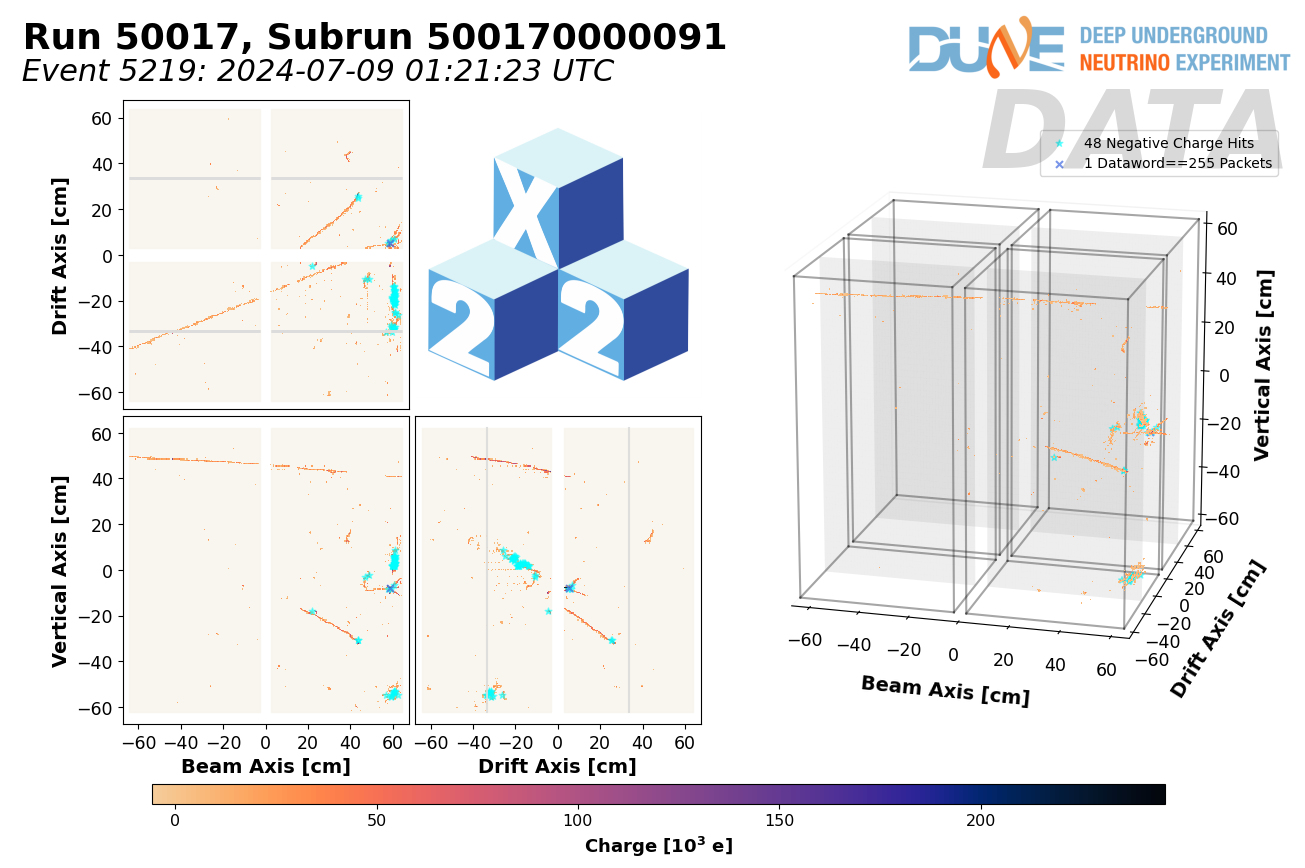

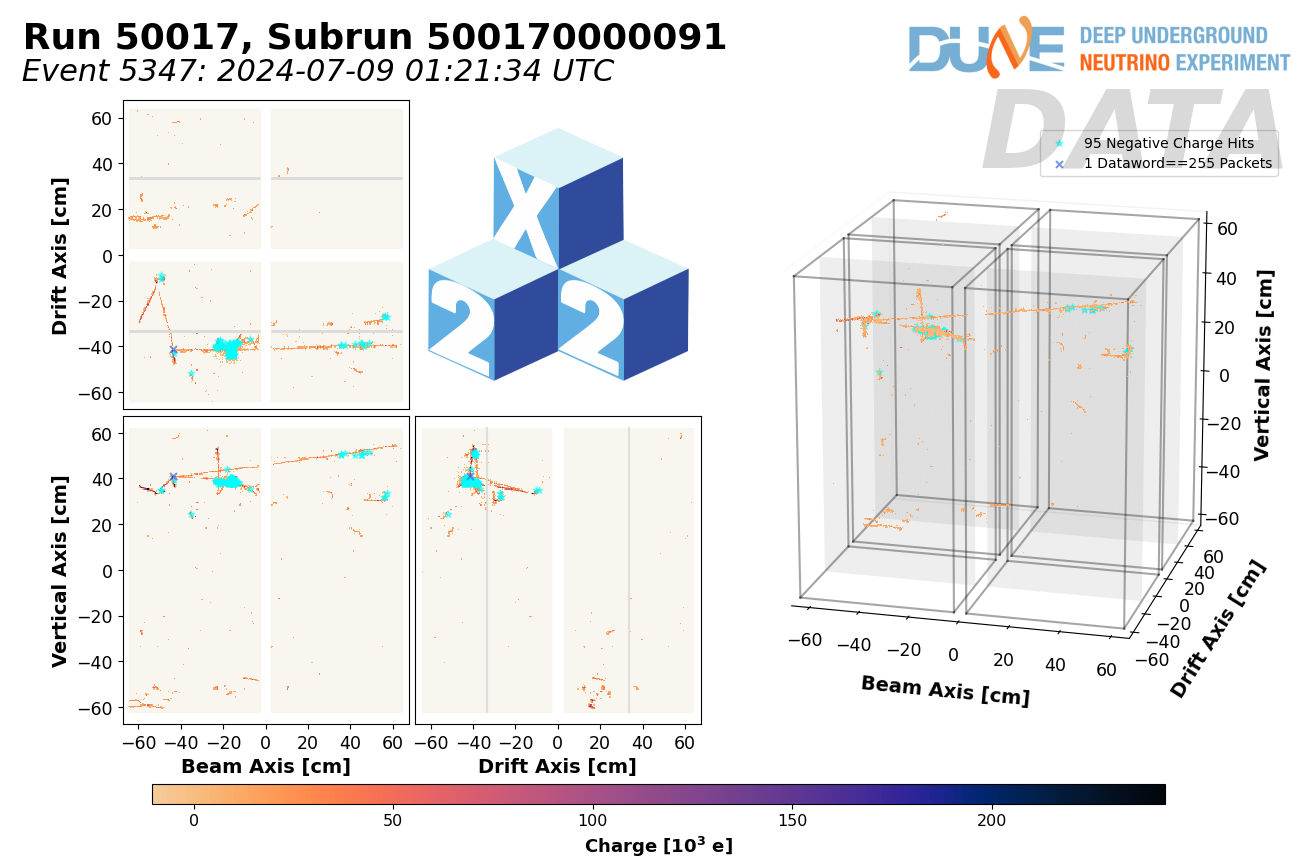

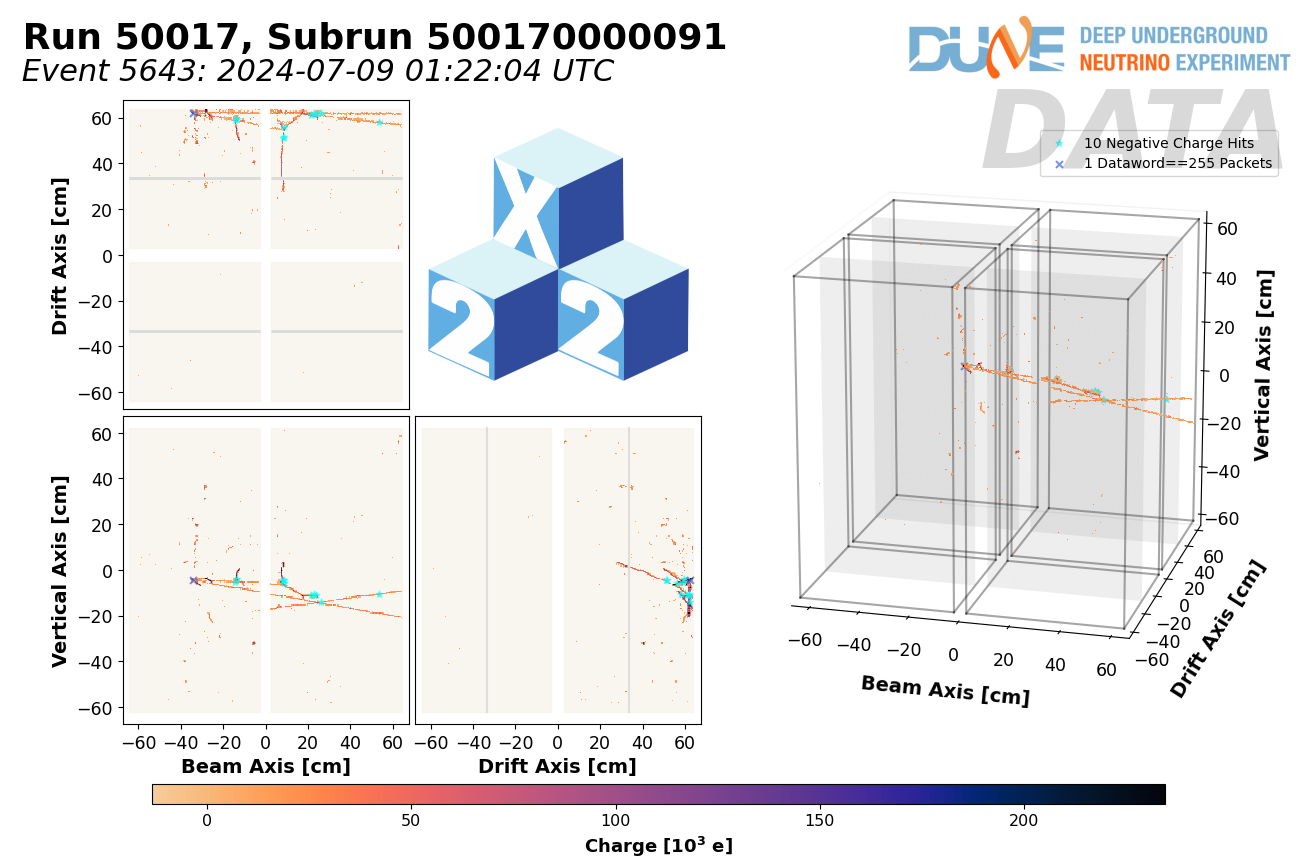

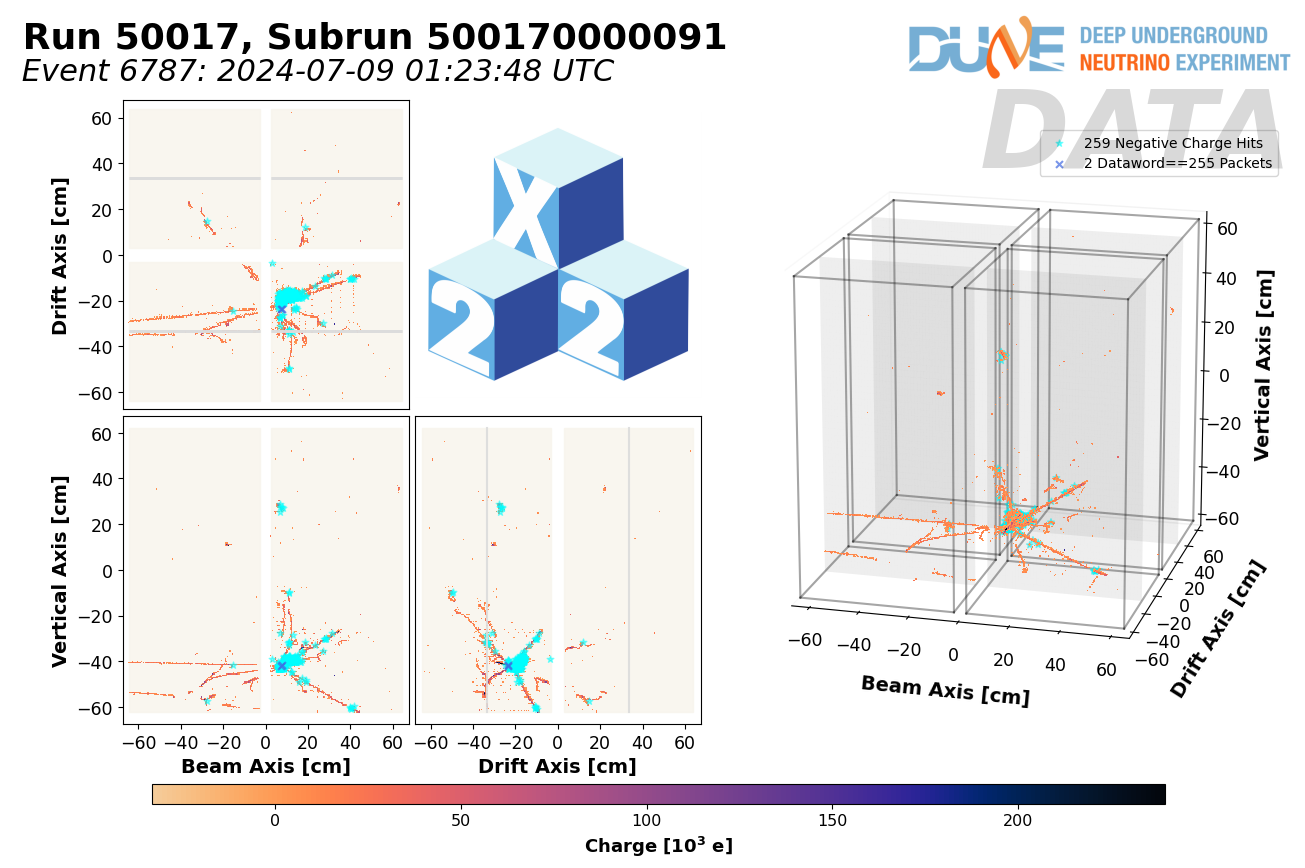

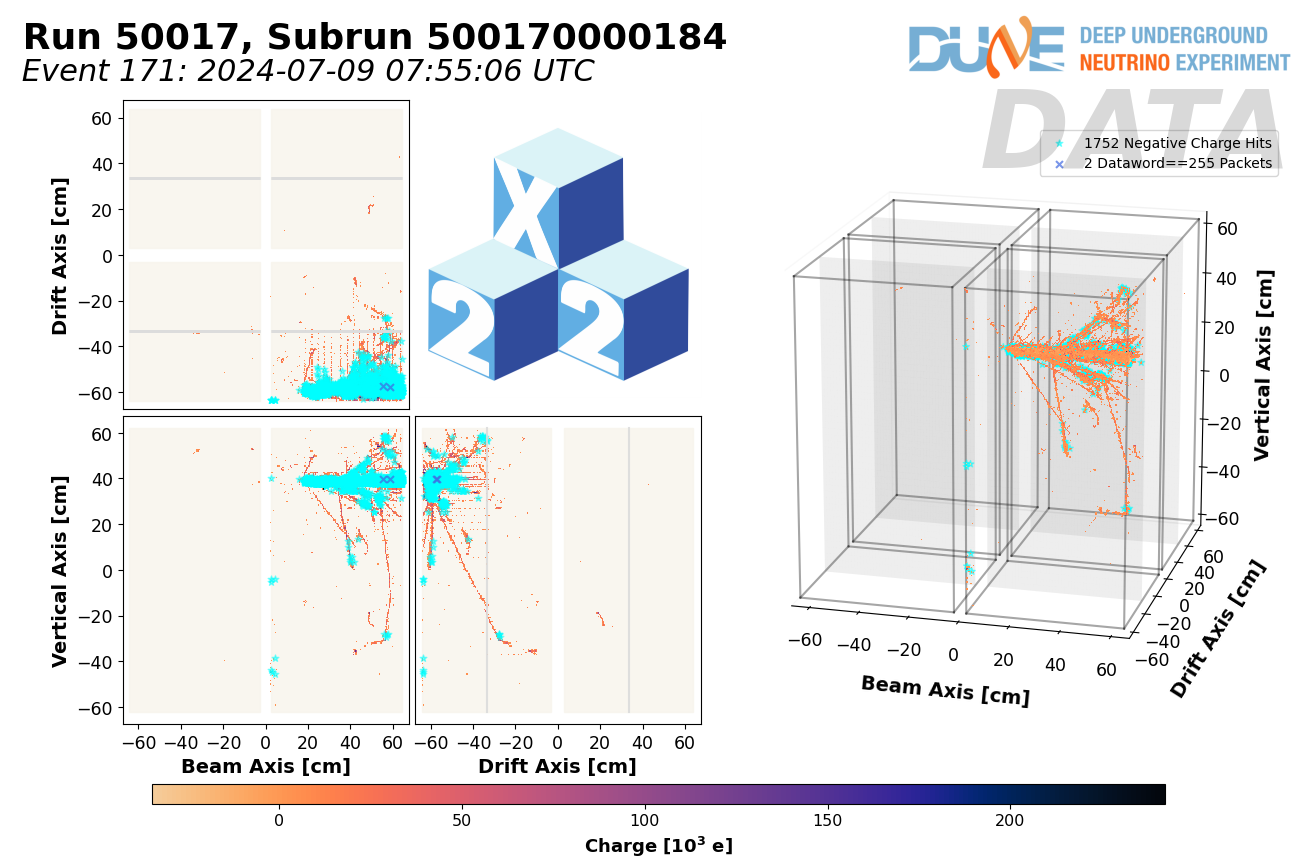

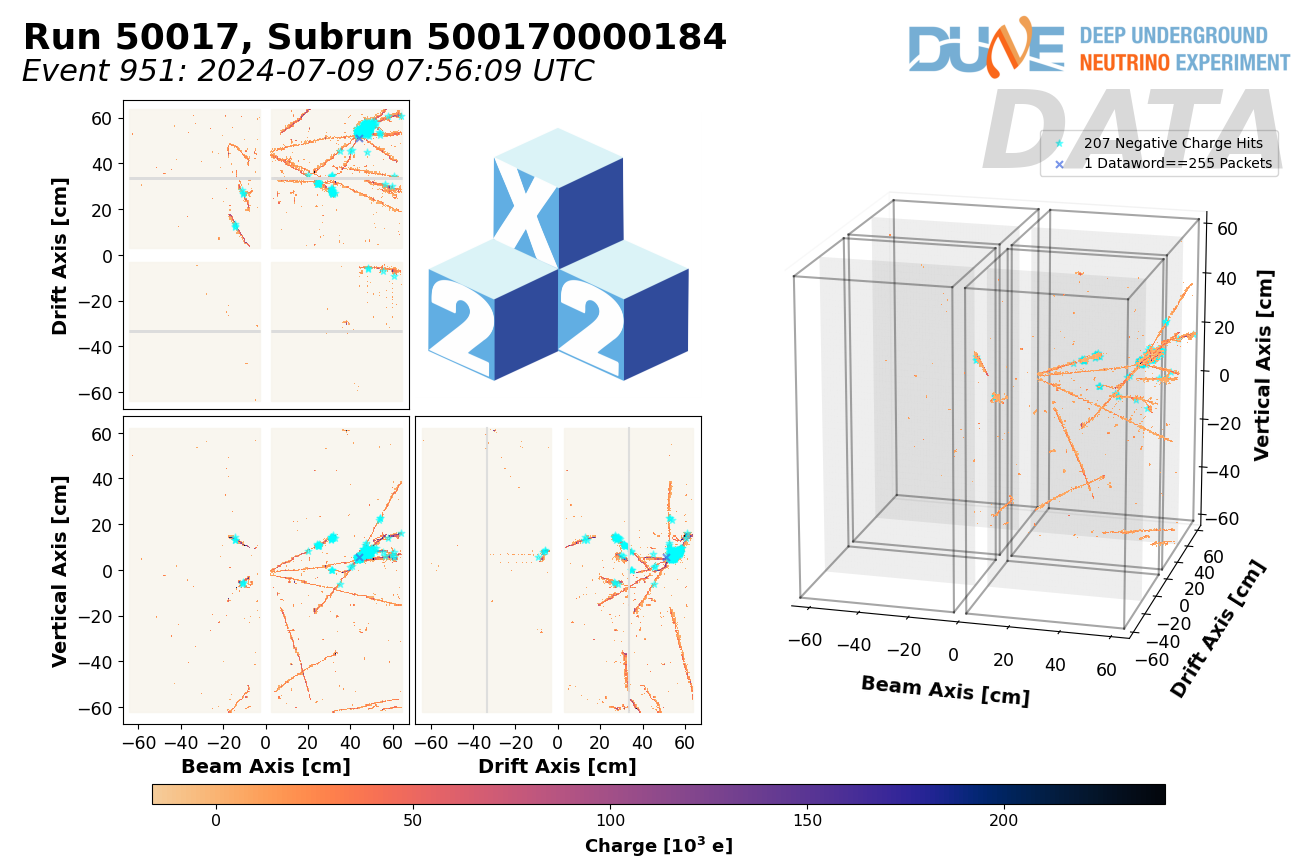

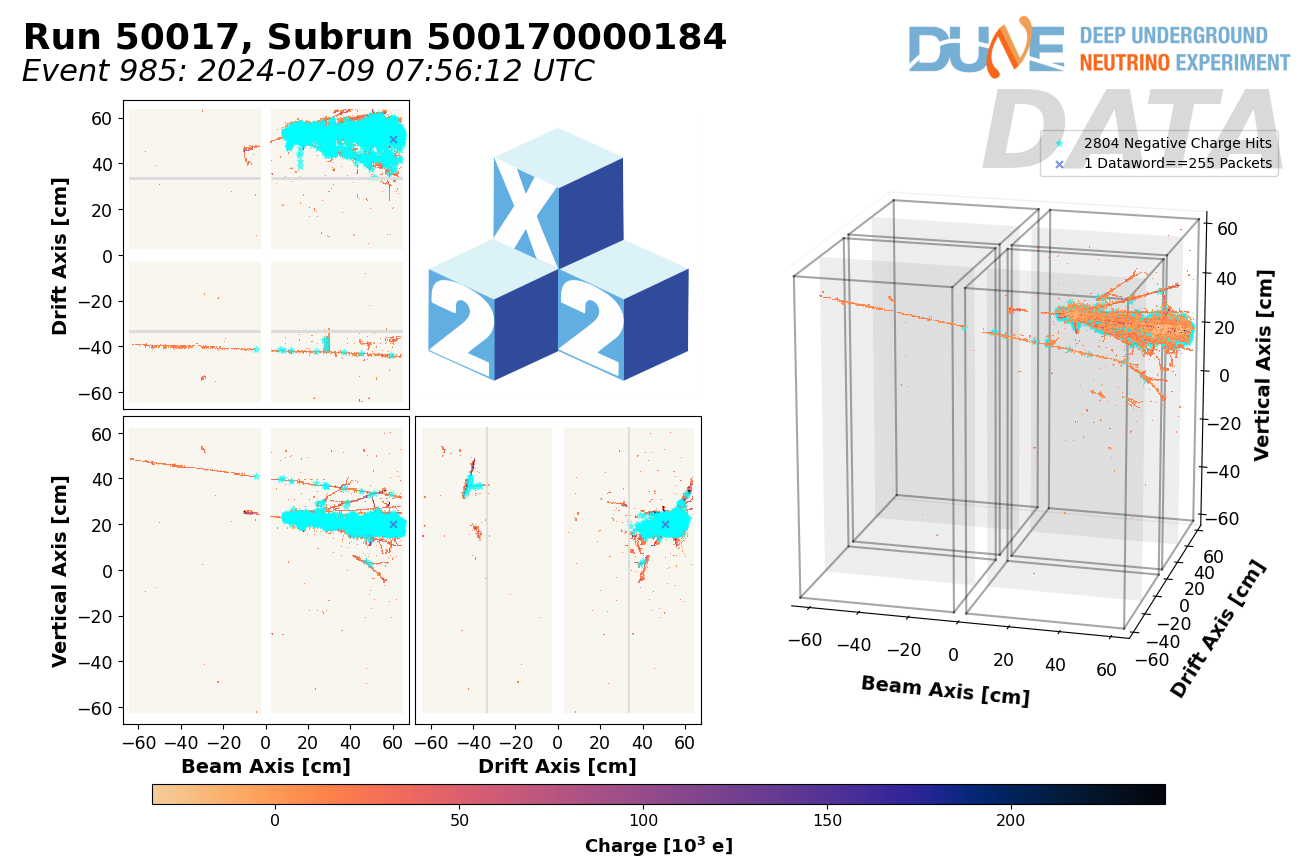

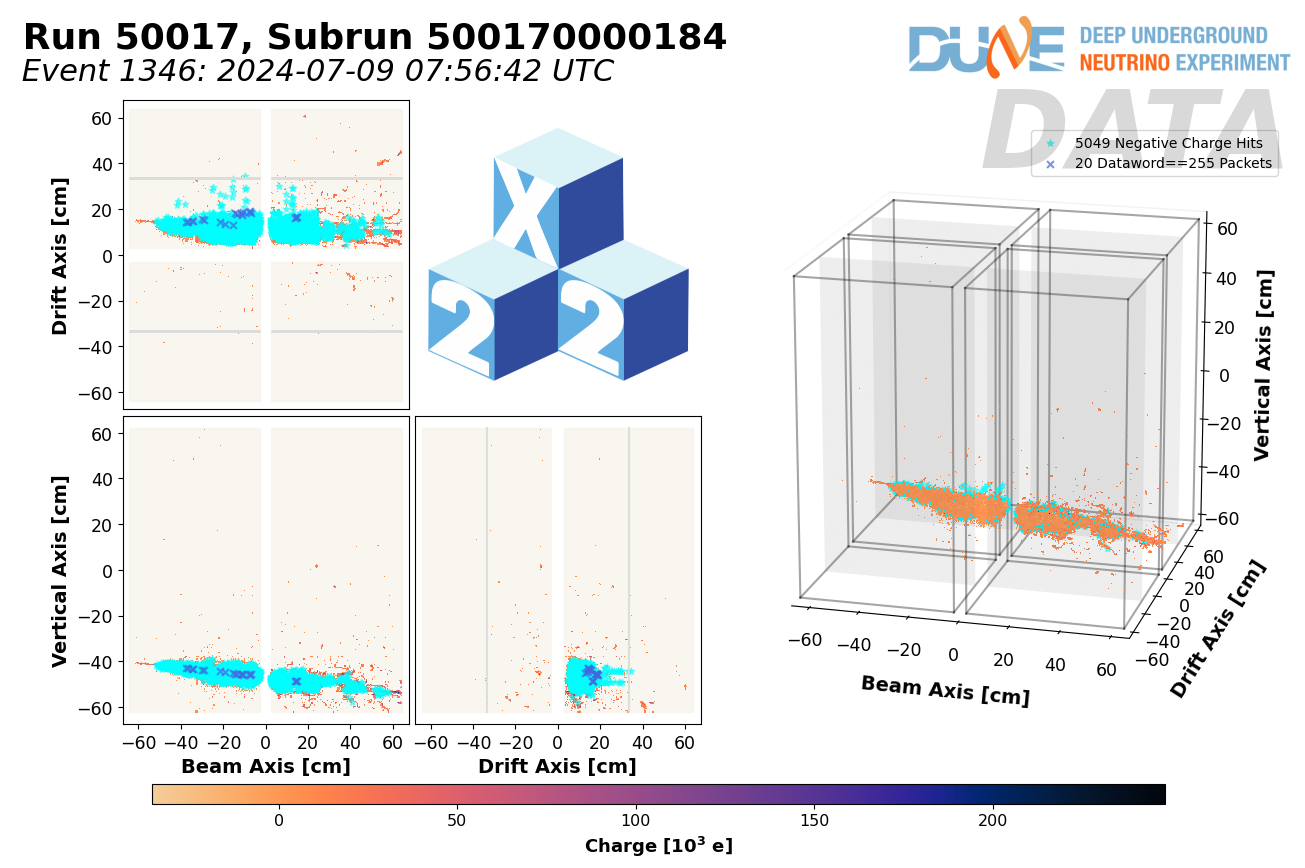

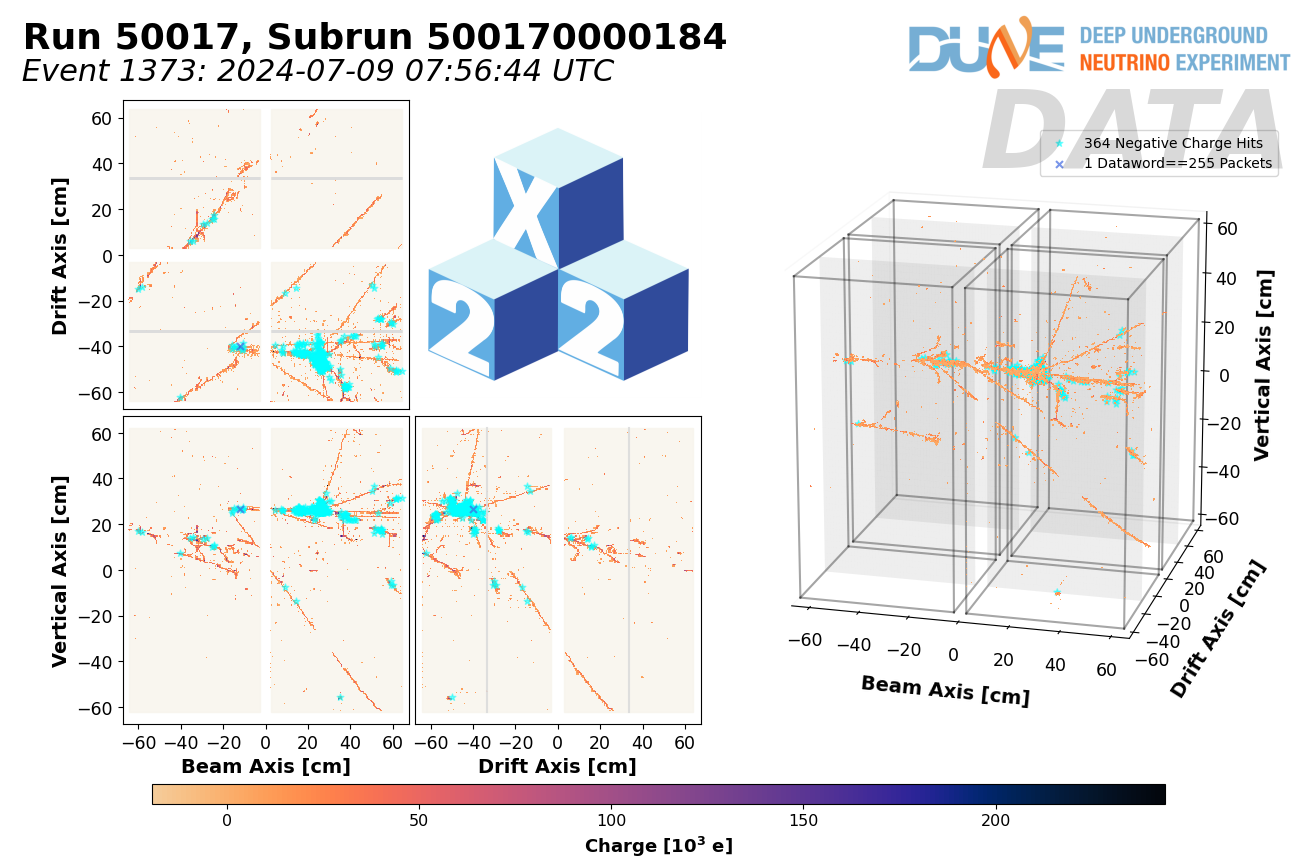

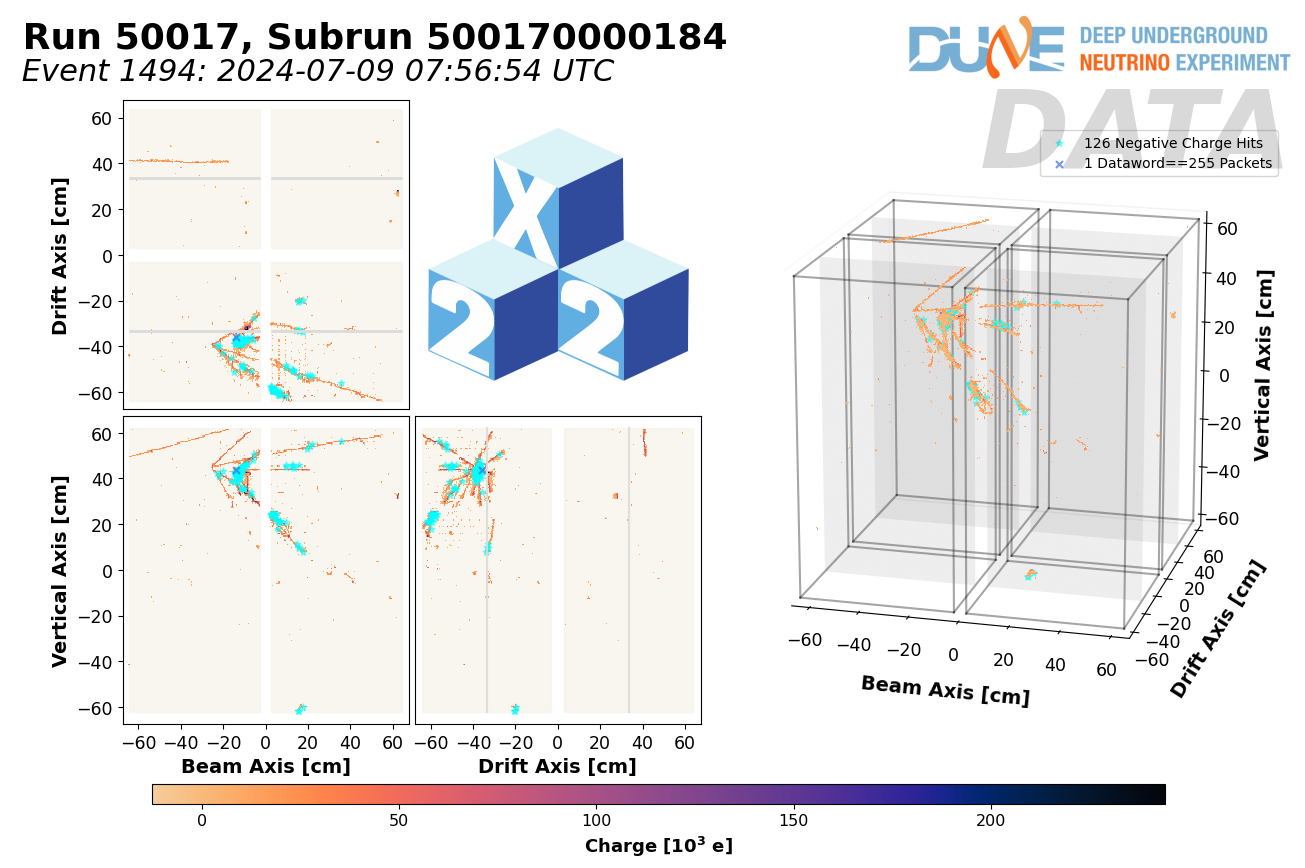

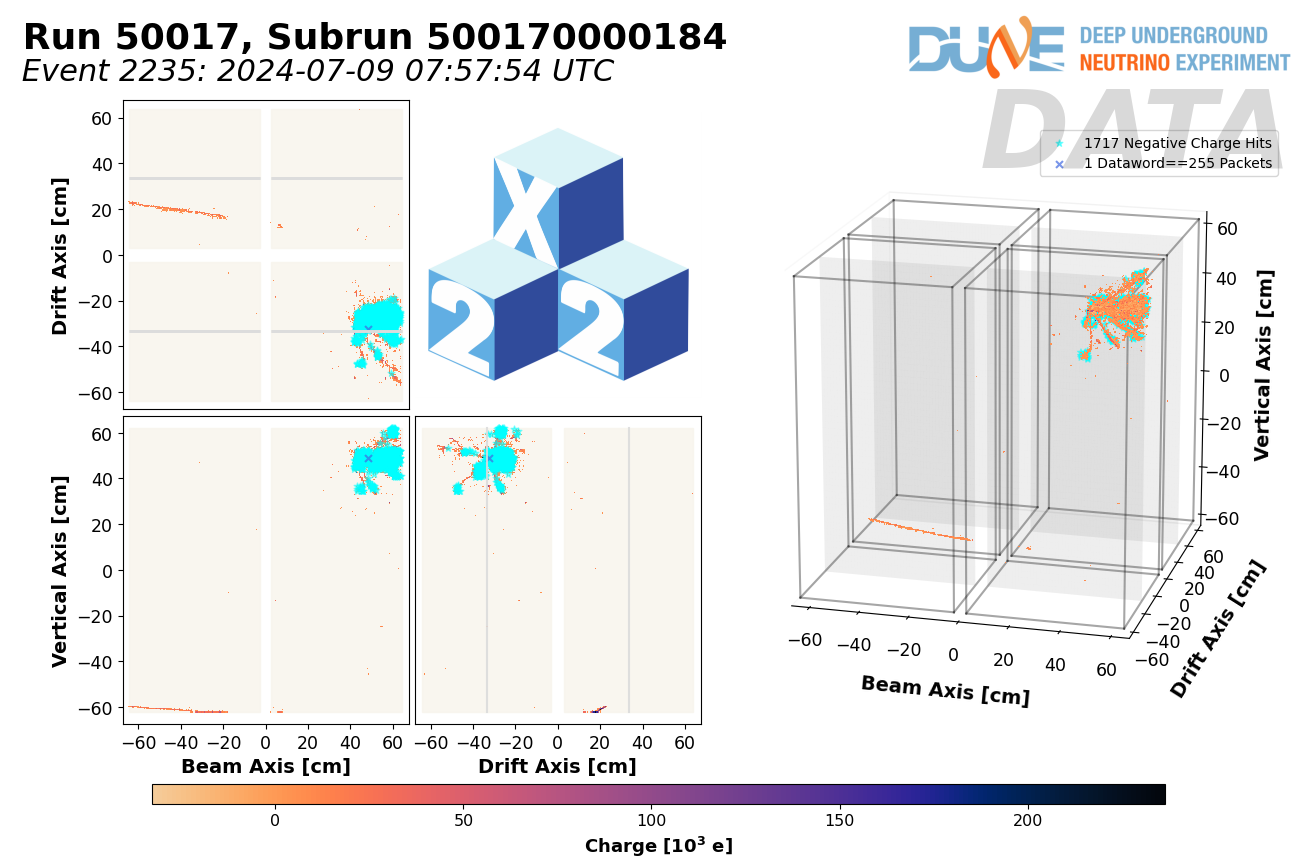

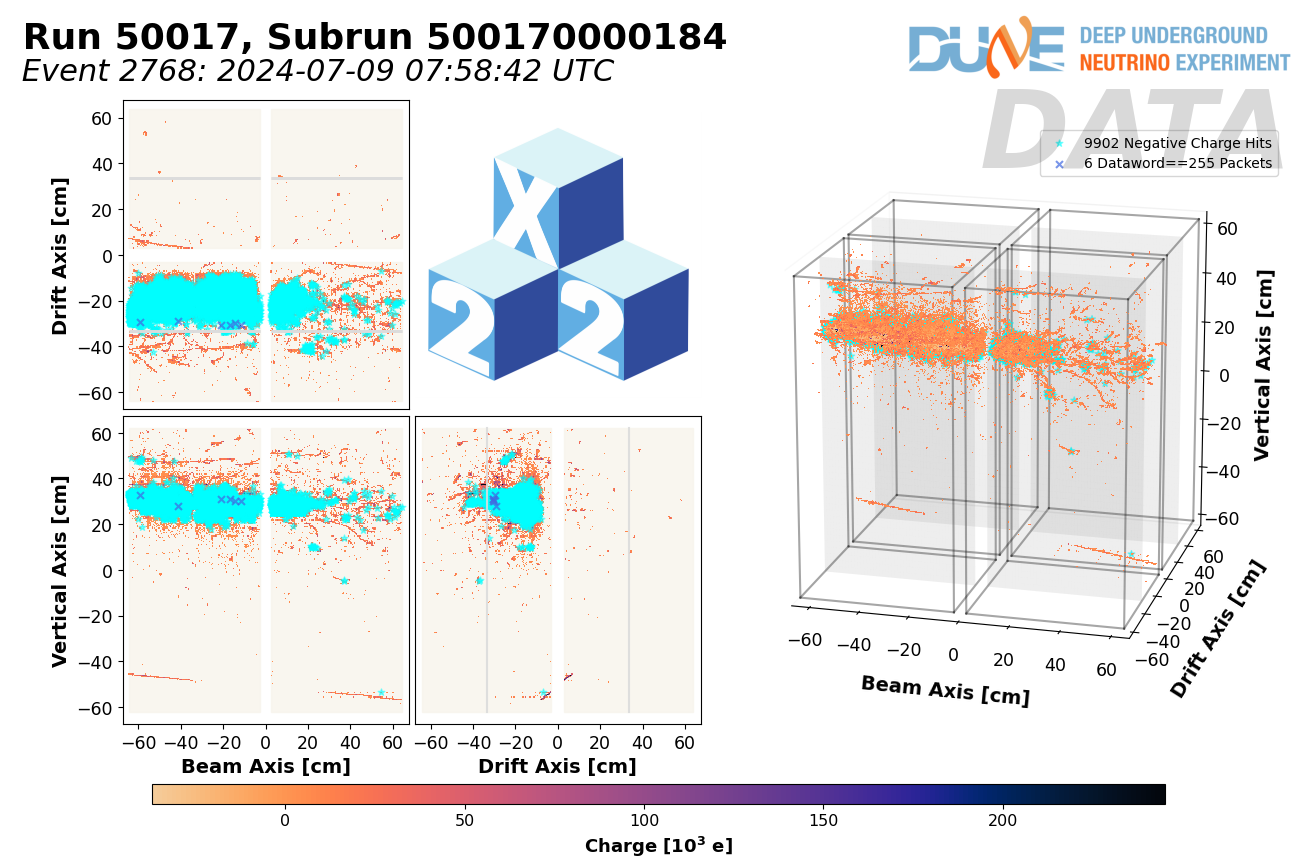

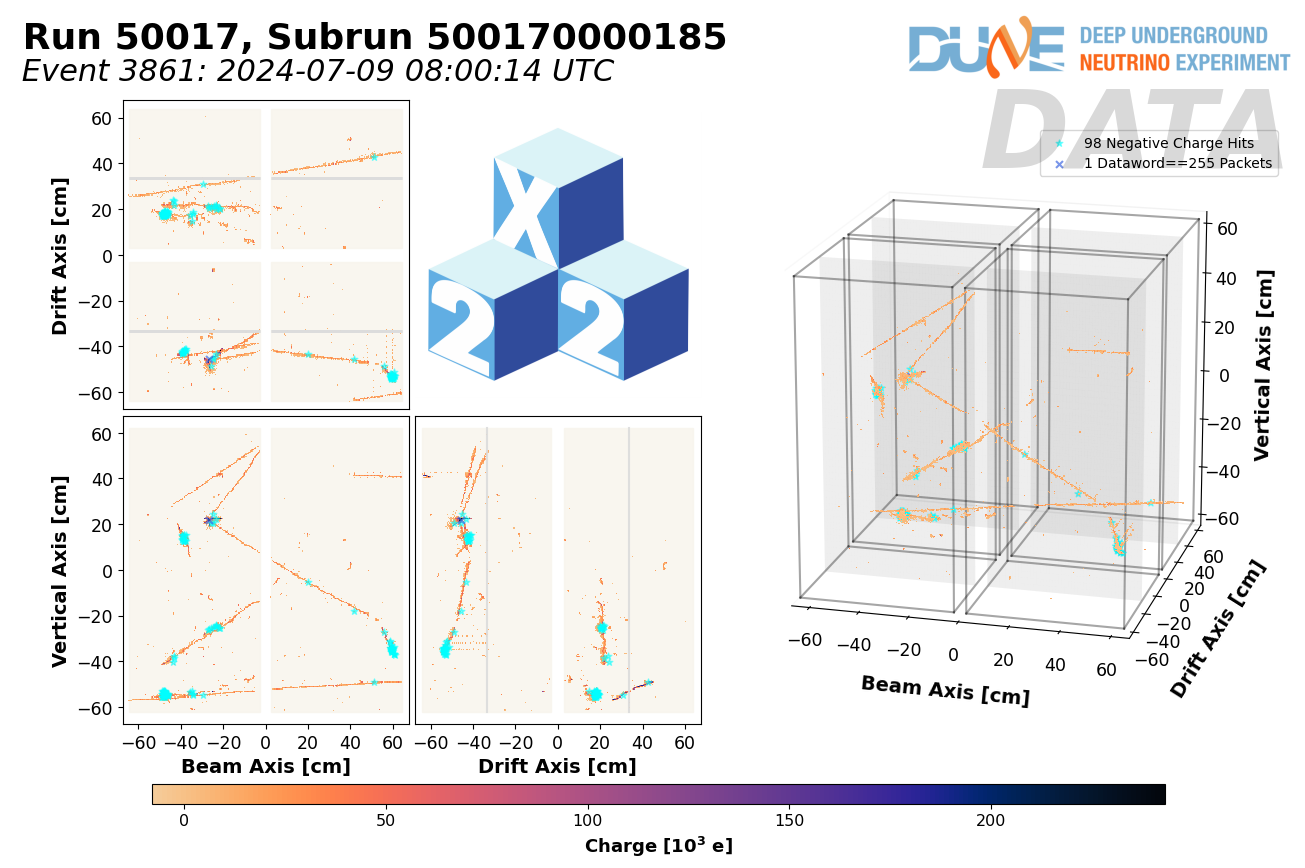

In [17]:
# This cell allows for the creation of a PDF showing events with ADC saturation with the relevant hits highlighted 
# (i.e. plotted over the event display with a blue X marker). Negative charge hits from ADC drift are also plotted with a cyan asterisk
# while PDF savefig lines are commented, the event displays will be shown in the notebook. 

#output_pdf_name = 'full_tile_trig_events_negative_charge_hits_and_adc_sat_packets.pdf'
output_pdf_name = 'adc_sat_V4_negative_charge_hits_and_adc_sat_packets.pdf'
with PdfPages(output_pdf_name, keep_empty=False) as output:
    counter = 0
    for keys, values in adc_sat_dict_remove_noisy_channels.items():
        counter += 1
        if counter < 16: continue
        if counter > 30: break
        if counter%10 == 0: print('--------------- LOOKING AT EVENT NUMBER: ', counter, '---------------')
        file = values['filepath'].split('/')[-1]
        directory = values['filepath'].split('packet')[0]
        directory = directory.replace('v1', 'v4')
        print("Directory:", directory)
        ev_id = values['event_id']

        evd = LArEventDisplay(filedir=directory, filename=file, nhits=values['nhits']-1, ntrigs=0, show_light=False, show_colorbars=True, beam_only=True)
        hits_ini, cmap_ini, charge_norm_ini = evd.display_event(ev_id)
        #output.savefig(bbox_inches='tight')
        #plt.close()
        hits, cmap, charge_norm = evd.display_event(ev_id)
        f = h5py.File(directory+file,'r')
        events = f['charge/events/data']
        event_mask = events['id'] == ev_id
        event = events[event_mask]
        hits_ref = f['charge/events/ref/charge/calib_prompt_hits/ref']
        hits_region = f['charge/events/ref/charge/calib_prompt_hits/ref_region']
        packets_full = f['charge/packets/data']
        packets_ref = f['charge/calib_prompt_hits/ref/charge/packets/ref']
        packets_hit_ref = f['charge/calib_prompt_hits/ref/charge/packets/ref']
        hit_ref = hits_ref[hits_region[ev_id,'start']:hits_region[ev_id,'stop']]
        hit_ref = np.sort(hit_ref[hit_ref[:,0] == ev_id, 1])
        packet_ref = packets_ref[hit_ref]
        packet_ref = np.sort(packet_ref[:, 1])
        packets = packets_full[packet_ref]
        adc_sat_idx = np.where(packets['packet_type']==0) and np.where(packets['dataword']==255)
        adc_sat_hits_ref = np.sort(packets_hit_ref[:,0][adc_sat_idx])
        sat_hits = hits[adc_sat_hits_ref]
        negative_charge_hits = hits[hits['Q']<0]
        #sat_hits = hits[hits['Q']>245]
        evd.ax_bdv.scatter(negative_charge_hits['z'], negative_charge_hits['x'], negative_charge_hits['y'], c='aqua', s=25, alpha=0.50, marker='*', label=str(len(negative_charge_hits))+' Negative Charge Hits')
        evd.ax_bd.scatter(negative_charge_hits['z'], negative_charge_hits['x'], c='aqua', s=25, alpha=0.50, marker='*')
        evd.ax_bv.scatter(negative_charge_hits['z'], negative_charge_hits['y'], c='aqua', s=25, alpha=0.50, marker='*')
        evd.ax_dv.scatter(negative_charge_hits['x'], negative_charge_hits['y'], c='aqua', s=25, alpha=0.50, marker='*')
        evd.ax_bdv.scatter(sat_hits['z'], sat_hits['x'], sat_hits['y'], c='royalblue', s=25, alpha=0.70, marker='x', label=str(len(sat_hits))+' Dataword==255 Packets')
        evd.ax_bd.scatter(sat_hits['z'], sat_hits['x'], c='royalblue', s=25, alpha=0.70, marker='x')
        evd.ax_bv.scatter(sat_hits['z'], sat_hits['y'], c='royalblue', s=25, alpha=0.70, marker='x')
        evd.ax_dv.scatter(sat_hits['x'], sat_hits['y'], c='royalblue', s=25, alpha=0.70, marker='x')
        evd.ax_bdv.legend()
        #output.savefig(bbox_inches='tight')
        #plt.close()

In [4]:
# This cell was exploratory in its attempt to identify other patterns in events with ADC saturation packets. It is not necessary for the main analysis.

#for keys, values in adc_sat_dict.items():
#    if values['adc_sat_packets_iog'] == [1,8]:
#        print(keys)

#file = '/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v1/beam/july10_2024/nominal_hv/packet-0050018-2024_07_11_12_29_05_CDT.FLOW.hdf5'
#ev_id = 2944
file = '/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_charge/REFLOW/v4/beam/july10_2024/nominal_hv/packet-0050018-2024_07_11_08_08_37_CDT.FLOW.hdf5'
ev_id = 3572

with h5py.File(file, 'r') as f:
    
    print(f['charge'].keys())
    events = f['charge/events/data']
    hits_full = f['charge/calib_prompt_hits/data']
    hits_ref = f['charge/events/ref/charge/calib_prompt_hits/ref']
    hits_region = f['charge/events/ref/charge/calib_prompt_hits/ref_region']
    packets_full = f['charge/packets/data']
    packets_ref = f['charge/calib_prompt_hits/ref/charge/packets/ref']

    event_mask = events['id'] == ev_id
    event = events[event_mask]
    hit_ref = hits_ref[hits_region[ev_id,'start']:hits_region[ev_id,'stop']]
    hit_ref = np.sort(hit_ref[hit_ref[:,0] == ev_id, 1])
    hits = hits_full[hit_ref]
    packet_ref = packets_ref[hit_ref]
    packet_ref = np.sort(packet_ref[:, 1])
    packets_event = packets_full[packet_ref]

    dict_key = file+'-'+str(ev_id)
    unique_channels_with_adc_sat_packets = adc_sat_dict[dict_key]['unique_channels_impacted']
    print("Unique channels with ADC Saturation packets: ", unique_channels_with_adc_sat_packets)
 
    for chan in unique_channels_with_adc_sat_packets:
        io_group_mask = packets_event['io_group'] == chan[0]
        packets = packets_event[io_group_mask]
        io_channel_mask = packets['io_channel'] == chan[1]
        packets = packets[io_channel_mask]
        chip_id_mask = packets['chip_id'] == chan[2]
        packets = packets[chip_id_mask]
        channel_id_mask = packets['channel_id'] == chan[3]
        packets = packets[channel_id_mask]
        plt.scatter(packets['timestamp'], packets['dataword'], label="Packets", color='blue')

        adc_sat_idx = np.where(
            (packets_event['io_group'] == chan[0]) &
            (packets_event['io_channel'] == chan[1]) &
            (packets_event['chip_id'] == chan[2]) &
            (packets_event['channel_id'] == chan[3])
        )        
        print(packets_event[adc_sat_idx])
        adc_sat_hits_ref = np.sort(packets_ref[:,0][adc_sat_idx])
        adc_sat_hits = hits[adc_sat_hits_ref]
        print(adc_sat_hits.dtype.names)
        plt.scatter(adc_sat_hits['ts_pps'], adc_sat_hits['Q'], label='Hits', color='red')
        plt.legend()
        print("Hit yz:", adc_sat_hits['y'], adc_sat_hits['z'])
        print("Hit Q:", adc_sat_hits['Q'])

    

<KeysViewHDF5 ['calib_final_hits', 'calib_prompt_hits', 'events', 'ext_trigs', 'packets', 'packets_corr_ts', 'raw_events', 'raw_hits']>


NameError: name 'adc_sat_dict' is not defined

TypeError: object of type 'numpy.float64' has no len()

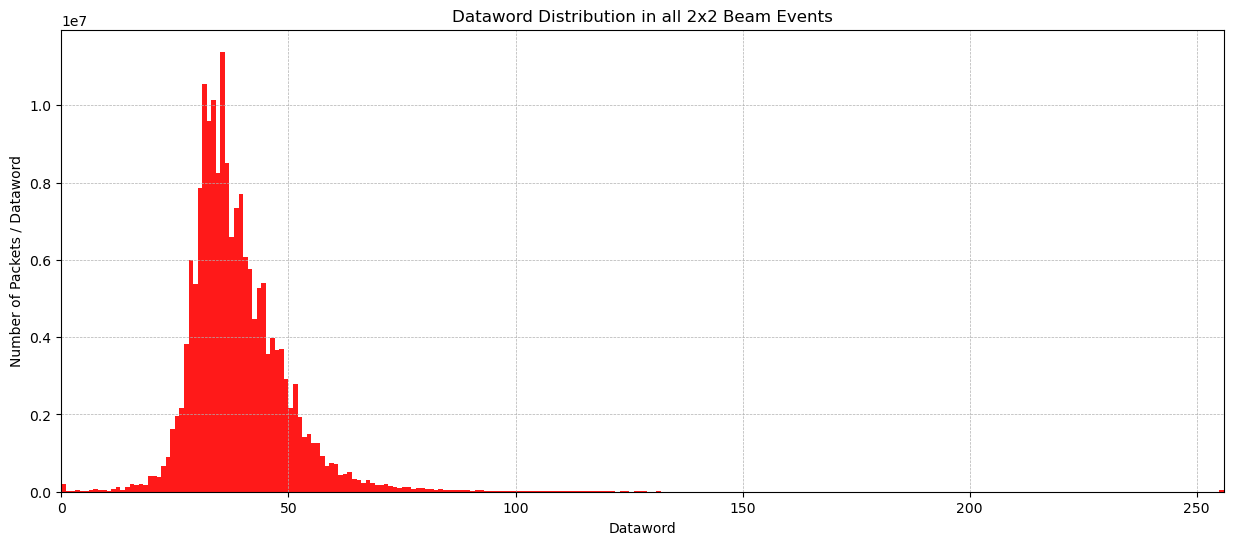

In [12]:
# This cell was exploratory in terms of its use to look at a different dictionary created to look at all datawords recorded in 2x2
# It is not necessary for the main study of ADC saturation packets and requires an additional dictionary to be created. I leave it here for completeness, but
# I suggest recreating such a dictionary for more detailed study if this line of inquiry is pursued.

all_dw_file = '/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/event_display/LAr_evd/all_datawords_dict.json'
all_dw_open = open(all_dw_file)
all_dw_dict = json.load(all_dw_open)

possible_dw = np.linspace(0, 256, 257)
dw_counts = np.zeros(256)
#print(possible_dw)
for key, value in all_dw_dict.items():
    for i in range(len(all_dw_dict[key]['datawords'])):
        #print(all_dw_dict[key]['datawords'][i])
        #print(all_dw_dict[key]['dw_counts'][i])
        dw_counts[all_dw_dict[key]['datawords'][i]] += all_dw_dict[key]['dw_counts'][i]
plt.figure(figsize=(15, 6))
#plt.yscale('log')
plt.xlabel('Dataword')
plt.ylabel('Number of Packets / Dataword')
plt.title('Dataword Distribution in all 2x2 Beam Events')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.hist(possible_dw[:-1], bins=possible_dw, weights=dw_counts, color='red', alpha=0.9)
#plt.axvline(255, color='red', linestyle='dashed')
#plt.axvline(0, color='red', linestyle='dashed')
plt.xlim(0, 256)
print(len(dw_counts[250]))




In [104]:
#print(100*(sum(dw_counts[251:])/sum(dw_counts)))

0.018168266827256196
